<div class="markdown-google-sans">
  <h1><font size=6>Assignment 1</font></h1>

  <u>Group members:</u><br>
  - Ariel Hedvat<br>
  - Shiraz Israeli<br>
  - Yuval Bakirov<br>
  - Eitan Bakirov

<br>

In this project we are aiming to build an accurate model to predict daily bicycle rental demand using the provided bike sharing dataset. By analyzing the data and testing different modeling techniques, we will develop a robust model optimized to forecast the rental count metric on a held-out test set.<br>
The goal is to create a reliable demand prediction model for bike sharing operations.
</div>




*   כדאי להשתמש במודלים מבוססי עצים: xgboost, random forest
*   להעלות את המחברת לגיט האב ולשים את הקישור בתיבת הגשה וגם את הסי-אס-וי








<div style="text-align: center;" class="markdown-google-sans">
  <h1><font size=5>Data</font></h1>
</div>

`train.csv` and `test.csv` - contain information on bike rentals, including the timestamp, seasonal indicators, holiday and working day flags, weather conditions, temperature metrics, humidity, windspeed, pollution, sunlight, traffic, and the count of bikes rented at each recorded time.<br>
Target variable to predict is "count" (Label).<br><br>


למחוק לפני הגשה:<br>

---


<u>datetime</u> - time of rental<br>
<u>season</u> - (1:winter, 2:spring, 3:summer, 4:fall)<br>
<u>holiday</u> - (Is it a bank holiday? If so: 1, else 0)<br>
<u>workingday</u> - (Is it a working day? If so: 1, else 0)<br>
<u>weather</u>
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

<u>temp</u> - temperature <br>
<u>atemp</u> - average temperature <br>


---


<div class="markdown-google-sans">
  <h1><font size=5>Table of Contents</font></h1>

>>[Import Libraries](#scrollTo=-_VBJ0JlYLKI)

>>[Loading the data](#scrollTo=kXwOL606ZfUN)

>[EDA - Exploring Data Analysis](#scrollTo=P8cTl07AZgyg)

>>[Date time Features - Time Series](#scrollTo=W55ei0QSyPJ7)

>>[Features Analysis](#scrollTo=kMEpr4k3j2G6)

>>>[Categorical Features distribution](#scrollTo=jwF74W59qwf_)

>>>[Numerical Features Distribution](#scrollTo=MBRxfPjgrXVc)

>>[Label Analysis](#scrollTo=bCeLkOkokIWH)

>>[Correlation](#scrollTo=-OtGfcjyFnSI)

>>[Missing Values](#scrollTo=G15IFI5TrScB)

>>[Outliers Visualization](#scrollTo=rot7m6iisI_v)

>[Preprocessing](#scrollTo=E_OOmtAYZnm7)

>>[Add / Remove Features](#scrollTo=96lau3rN1OpT)

>>[Handling Categorial Features](#scrollTo=xtPSG9CixFck)

>[need to fix from here!](#scrollTo=Rk9_HR1Xcl1-)

>>[Outliers](#scrollTo=zxs7JyHhxIoa)

>>[Data Normalizing](#scrollTo=NiFHiz6MxXGT)

>>[PCA - Dimensionality Reduction](#scrollTo=iaFEPiItxaqq)

>>[Final Preprocessing Function](#scrollTo=6TXc09TPPJe0)

>[Modeling](#scrollTo=PujsQcU7Zw5v)

>>[Random forest](#scrollTo=9d7kvNFC4WEr)

>>[XGBoost](#scrollTo=gtCPfdY170cL)

>>[Linear regression](#scrollTo=rZfkDfpN72nT)

>>[Run all models](#scrollTo=ALLMKt0F4n1T)

>[Evaluating on validation set](#scrollTo=qbvc7vxiZ5fC)

>>[Overall comparison](#scrollTo=YXDGMG-H6Ey2)

>>[Feature selection & importance](#scrollTo=Y7M2ZqsX6Ofl)

>>>>[Tree based methods](#scrollTo=jl-WQpBxG49h)

>>>>[Classical regression methods](#scrollTo=eqYG1lEsG8Aa)

>>>>[Comparison](#scrollTo=aFVaV87mICFL)

>>[Add/Remove Features - Improve Results](#scrollTo=GE5x3tkL9IwM)

>>[Model improvement](#scrollTo=RGzmhm996-4c)

>[Prediction](#scrollTo=dE4SF0VdaENB)

>[Output](#scrollTo=IJrSf6hnWnCJ)



##  Import Libraries

In [82]:
import pandas as pd
import numpy as np
import sklearn as skl
import seaborn as sns
import os
import scipy.stats as stats

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import math
from datetime import datetime, timedelta

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, IsolationForest

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [83]:
# Data Loading for Train
url = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/Assignment%20I/train.csv'
full_train_data = pd.read_csv(url)

train_with_labels = full_train_data.copy()
train_data = full_train_data.drop('count', axis=1).copy()
train_labels = full_train_data['count'].copy()

In [84]:
# Data Loading for Test
url_test = 'https://raw.githubusercontent.com/ariel-hedvat/AdvancedMLDLCourseAssignments/main/Assignment%20I/test.csv'
full_test_data = pd.read_csv(url_test)

test_with_labels = full_test_data.copy()
test_data = full_test_data.drop('count', axis=1).copy()
test_labels = full_test_data['count'].copy()

# **EDA - Exploring Data Analysis**

A glimpse of the data frame

In [85]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic
0,2011-07-11 00:00:00,3,0,1,1,28.70,32.575,65,12.9980,5.354100,28.701,0.000000
1,2012-05-18 22:00:00,2,0,1,1,22.96,26.515,52,22.0028,85.425233,22.961,0.004489
2,2011-04-01 23:00:00,2,0,1,1,12.30,15.910,61,6.0032,2.040899,12.301,0.000242
3,2012-09-16 09:00:00,3,0,0,1,23.78,27.275,60,8.9981,26.682772,23.781,0.004489
4,2011-02-01 23:00:00,1,0,1,3,8.20,9.850,93,12.9980,5.851754,8.201,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
8159,2012-01-14 02:00:00,1,0,0,1,6.56,8.335,47,11.0014,14.953355,6.561,0.004489
8160,2011-12-10 09:00:00,4,0,0,1,11.48,12.880,61,19.0012,7.977025,11.481,0.000000
8161,2011-12-18 16:00:00,4,0,0,1,11.48,13.635,48,16.9979,6.916512,11.481,0.015615
8162,2011-02-19 07:00:00,1,0,0,1,15.58,19.695,17,35.0008,0.095445,15.581,0.000242


In [86]:
train_data.shape

(8164, 12)

Dropping duplicates

In [87]:
train_data = train_data.drop_duplicates()

And again

In [88]:
train_data.shape

(8164, 12)

It can be seen that there were no identical samples in the data <br><br>Next, let's take a look at the types of features that exist:

In [89]:
train_data.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
pollution     float64
sunlight      float64
traffic       float64
dtype: object

Based on our knowledge of the features and the data displayed above we can conclude that: <br>

Our dataset consists 12 features and 8164 observations.
The features types :

<span style="color: orange;">`datetime`</span> is <b><u>Datetime</u></b> data type. <br>

<span style="color: #6699CC;">`temp`</span>, <span style="color: #6699CC;">`atemp`</span>, <span style="color: #6699CC;">`humidity`</span>, <span style="color: #6699CC;">`windspeed`</span>, <span style="color: #6699CC;">`pollution`</span>, <span style="color: #6699CC;">`sunlight`</span> and <span style="color: #6699CC;">`traffic`</span> - are <b><u>Numeric</u></b> data types. <br>

<span style="color: green;">`holiday`</span> and <span style="color: green;">`workingday`</span> - are <b><u>Boolean </b></u> data types.<br>

<span style="color: orange;">`season`</span> and <span style="color: orange;">`weather`</span> - are <b><u>Categorical</u></b> data types.

Hence we will update the data types of each feature:


In [90]:
numeric_features = [col for col in ['temp', 'atemp', 'humidity', 'exports', 'windspeed', 'pollution', 'sunlight', 'traffic'] if col in train_data.columns]
boolean_features = [col for col in ['holiday', 'workingday'] if col in train_data.columns]
categorical_features = [col for col in ['season', 'weather'] if col in train_data.columns]
datetime_features = ['datetime']
# features = TODO put all inside maybe

In [91]:
def change_data_types(df):

    numeric_features = [col for col in ['temp', 'atemp', 'humidity', 'exports', 'windspeed', 'pollution', 'sunlight', 'traffice'] if col in df.columns]
    boolean_features = [col for col in ['holiday', 'workingday'] if col in df.columns]
    categorical_features = [col for col in ['season', 'weather'] if col in df.columns]

    # Convert 'datetime' to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Change numeric features to numeric data type
    df[numeric_features] = df[numeric_features].astype(float)

    # Change boolean features to boolean data type
    for col in boolean_features:
        df[col] = df[col].where(df[col].notnull(), np.nan).astype('boolean')

    # Change categorical features to categorical data type
    df[categorical_features] = df[categorical_features].astype('category')

    return df


In [92]:
train_data = change_data_types(train_data)
train_with_labels = change_data_types(train_with_labels)
test_data = change_data_types(test_data)

And after the changes:

In [93]:
train_data.dtypes

datetime      datetime64[ns]
season              category
holiday              boolean
workingday           boolean
weather             category
temp                 float64
atemp                float64
humidity             float64
windspeed            float64
pollution            float64
sunlight             float64
traffic              float64
dtype: object

In [94]:
train_with_labels.dtypes

datetime      datetime64[ns]
season              category
holiday              boolean
workingday           boolean
weather             category
temp                 float64
atemp                float64
humidity             float64
windspeed            float64
pollution            float64
sunlight             float64
traffic              float64
count                  int64
dtype: object

 ## **Date time Features - Time Series**

In this section we will check the time series attributes that the data has:

From looking at the datetime feature we see that we can seperate it to sub features: Day, Month, Year and Hour

But before separating the 'datetime' feature to sub features, we will check whether there are minutes and hours:

In [95]:
unique_times = train_data['datetime'].dt.strftime('%H:%M:%S').unique()

sorted_times = sorted(unique_times)

print("All unique times in train_data['datetime'], sorted:")
for time in sorted_times:
  print(time)

All unique times in train_data['datetime'], sorted:
00:00:00
01:00:00
02:00:00
03:00:00
04:00:00
05:00:00
06:00:00
07:00:00
08:00:00
09:00:00
10:00:00
11:00:00
12:00:00
13:00:00
14:00:00
15:00:00
16:00:00
17:00:00
18:00:00
19:00:00
20:00:00
21:00:00
22:00:00
23:00:00


In [96]:
# Count the number of unique hours
num_unique_hours = len(unique_times)

# Print the result
print(f"Number of unique hours: {num_unique_hours}")

Number of unique hours: 24


We observe that the 'datetime' column only includes hours without minutes and seconds. Therefore, we will add new features specifically for hours, days, month and year.



As you can see, bicycles can be rented at any time of the day.

In [97]:
def timeseries_engineering(df):
  df['day'] = df['datetime'].dt.day
  df['month'] = df['datetime'].dt.month
  df['year'] = df['datetime'].dt.year
  df['hour'] = df['datetime'].dt.hour

  # Change them to category type data
  df['day'] = df['day'].astype('category')
  df['month'] = df['month'].astype('category')
  df['year'] = df['year'].astype('category')
  df['hour'] = df['hour'].astype('category')

  df = df.sort_values(by='datetime')
  return df

These new features will replace the datetime feature when training the models. For now, we will leave the datetime feature in order to perform additional analysis on it.

In [98]:
train_data = timeseries_engineering(train_data)
train_with_labels = timeseries_engineering(train_with_labels)
test_data = timeseries_engineering(test_data)

In [99]:
train_with_labels.dtypes

datetime      datetime64[ns]
season              category
holiday              boolean
workingday           boolean
weather             category
temp                 float64
atemp                float64
humidity             float64
windspeed            float64
pollution            float64
sunlight             float64
traffic              float64
count                  int64
day                 category
month               category
year                category
hour                category
dtype: object

Let's look at the sorted data and maybe draw some new conclusions:

In [100]:
train_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,day,month,year,hour
6560,2011-01-01 01:00:00,1,False,False,1,9.02,13.635,80.0,0.0000,10.820673,9.021,0.000000,1,1,2011,1
3754,2011-01-01 02:00:00,1,False,False,1,9.02,13.635,80.0,0.0000,19.189498,9.021,0.004489,1,1,2011,2
7767,2011-01-01 04:00:00,1,False,False,1,9.84,14.395,75.0,0.0000,0.133472,9.841,0.015615,1,1,2011,4
7272,2011-01-01 05:00:00,1,False,False,2,9.84,12.880,75.0,6.0032,0.014335,9.841,0.000000,1,1,2011,5
5381,2011-01-01 06:00:00,1,False,False,1,9.02,13.635,80.0,0.0000,0.096936,9.021,0.004489,1,1,2011,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4763,2012-12-19 16:00:00,4,False,True,1,17.22,21.210,50.0,23.9994,19.956957,17.221,0.015615,19,12,2012,16
467,2012-12-19 18:00:00,4,False,True,1,15.58,19.695,50.0,23.9994,212.578827,15.581,0.004489,19,12,2012,18
4423,2012-12-19 19:00:00,4,False,True,1,15.58,19.695,50.0,26.0027,21.027171,15.581,0.015615,19,12,2012,19
3307,2012-12-19 20:00:00,4,False,True,1,14.76,17.425,57.0,15.0013,37.737255,14.761,0.004489,19,12,2012,20


In [101]:
start = str(train_data['datetime'].min())
end = str(train_data['datetime'].max())

print("Start: " + start[:10], "   Time: " + start[11:], "\nEnd:   " + end[:10], "   Time: " + end[11:])

Start: 2011-01-01    Time: 01:00:00 
End:   2012-12-19    Time: 21:00:00


Our data is all from the beginning of 2011 until December 19, 2012.

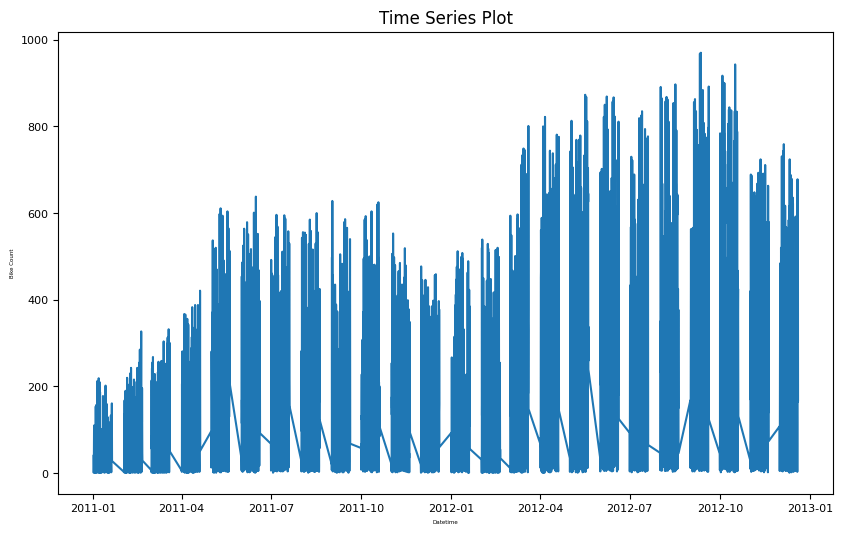

In [102]:
plt.figure(figsize=(10, 6))
plt.plot(train_with_labels['datetime'], train_with_labels['count'])
plt.title('Time Series Plot')
plt.xlabel('Datetime')
plt.ylabel('Bike Count')
plt.show()

It can be seen that in the first half of 2011 there was a monthly increase in the amount of rented bicycles, which changed direction to decrease in the second half of 2011. The amount of rented bicycles increased again starting from 2012 until the last quarter of that year.<br>
Moreover, we can see in the diagram many intervals of identical sizes. Let's try to understand better what they say:

In [103]:
def get_actual_and_missing_dates(df):
  unique_dates = df['datetime'].dt.date.unique()
  actual_date_strings = [str(date) for date in unique_dates]

  # Convert 'datetime' column to DatetimeIndex
  df_datetime_index = pd.DatetimeIndex(df['datetime'])

  # Get unique dates in the same format as 'expected_dates'
  expected_dates = pd.date_range(start=df_datetime_index.min(), end=df_datetime_index.max())

  # Convert expected_dates to an array of datetime.date objects
  expected_dates_array = np.array(expected_dates.date)

  expected_dates_strings = [str(date) for date in expected_dates_array]

  # Convert the date strings to sets
  expected_dates_set = set(expected_dates_strings)
  actual_dates_set = set(actual_date_strings)

  # Find the dates in expected_dates_set but not in actual_dates_set
  missing_dates = expected_dates_set - actual_dates_set

  # Convert the result back to a list
  missing_dates_list = list(missing_dates)
  actual_dates_list = list(actual_dates_set)

  # Sort the list to have the dates in ascending order
  missing_dates = sorted(missing_dates_list)
  actual_dates = sorted(actual_dates_list)

  print(f'Expected Days: {len(expected_dates_set)}')
  print(f'Actual Days: {len(actual_date_strings)}')
  print(f'Missing Days: {len(missing_dates)}')

  return actual_dates, missing_dates

In [104]:
actual_dates_train, missing_dates_train = get_actual_and_missing_dates(train_data)

Expected Days: 719
Actual Days: 456
Missing Days: 263


In [105]:
actual_dates_test, missing_dates_test = get_actual_and_missing_dates(test_data)

Expected Days: 719
Actual Days: 455
Missing Days: 264


There are 263 days in two years when bicycles were not rented.

Let's visualize the missing dates in some ways:

In [106]:
def print_missing_dates(missing_dates):
  if len(missing_dates) > 0:
      print("Missing dates:")
      # missing_dates = sorted(missing_dates)

      month_before = '01'
      for date in missing_dates:
        month = str(date)[5:8]
        if month != month_before:
          print("-----------------------------")
        print(str(date)[:10])
        month_before = month
  else:
      print("No missing dates")

In [107]:
print_missing_dates(missing_dates_train)

Missing dates:
-----------------------------
2011-01-20
2011-01-21
2011-01-22
2011-01-23
2011-01-24
2011-01-25
2011-01-26
2011-01-27
2011-01-28
2011-01-29
2011-01-30
2011-01-31
-----------------------------
2011-02-20
2011-02-21
2011-02-22
2011-02-23
2011-02-24
2011-02-25
2011-02-26
2011-02-27
2011-02-28
-----------------------------
2011-03-20
2011-03-21
2011-03-22
2011-03-23
2011-03-24
2011-03-25
2011-03-26
2011-03-27
2011-03-28
2011-03-29
2011-03-30
2011-03-31
-----------------------------
2011-04-20
2011-04-21
2011-04-22
2011-04-23
2011-04-24
2011-04-25
2011-04-26
2011-04-27
2011-04-28
2011-04-29
2011-04-30
-----------------------------
2011-05-20
2011-05-21
2011-05-22
2011-05-23
2011-05-24
2011-05-25
2011-05-26
2011-05-27
2011-05-28
2011-05-29
2011-05-30
2011-05-31
-----------------------------
2011-06-20
2011-06-21
2011-06-22
2011-06-23
2011-06-24
2011-06-25
2011-06-26
2011-06-27
2011-06-28
2011-06-29
2011-06-30
-----------------------------
2011-07-20
2011-07-21
2011-07-22
2011-

In [108]:
print_missing_dates(missing_dates_test)

Missing dates:
-----------------------------
2011-01-20
2011-01-21
2011-01-22
2011-01-23
2011-01-24
2011-01-25
2011-01-26
2011-01-27
2011-01-28
2011-01-29
2011-01-30
2011-01-31
-----------------------------
2011-02-20
2011-02-21
2011-02-22
2011-02-23
2011-02-24
2011-02-25
2011-02-26
2011-02-27
2011-02-28
-----------------------------
2011-03-20
2011-03-21
2011-03-22
2011-03-23
2011-03-24
2011-03-25
2011-03-26
2011-03-27
2011-03-28
2011-03-29
2011-03-30
2011-03-31
-----------------------------
2011-04-20
2011-04-21
2011-04-22
2011-04-23
2011-04-24
2011-04-25
2011-04-26
2011-04-27
2011-04-28
2011-04-29
2011-04-30
-----------------------------
2011-05-20
2011-05-21
2011-05-22
2011-05-23
2011-05-24
2011-05-25
2011-05-26
2011-05-27
2011-05-28
2011-05-29
2011-05-30
2011-05-31
-----------------------------
2011-06-20
2011-06-21
2011-06-22
2011-06-23
2011-06-24
2011-06-25
2011-06-26
2011-06-27
2011-06-28
2011-06-29
2011-06-30
-----------------------------
2011-07-20
2011-07-21
2011-07-22
2011-

It can be seen that bicycles were not rented on the days starting from the 20th of the month until the end of the month.<br>
Next, another look:

In [109]:
# Function to convert date strings to datetime objects
def convert_to_datetime(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d")

def plot_actual_dates(missing_dates):
  # Define the date range from 1/1/2011 to 1/1/2013
  start_date = datetime(2011, 1, 1)
  end_date = datetime(2013, 1, 1)
  date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

  # Convert missing_dates to datetime objects
  missing_dates_datetime = [convert_to_datetime(date_str) for date_str in missing_dates]

  # Create a list of binary values indicating if each date is missing or not
  missing_flags = [1 if date in missing_dates_datetime else 0 for date in date_range]

  # Identify consecutive ranges of missing and not missing dates
  ranges = []
  current_range = []
  for i, flag in enumerate(missing_flags):
      if flag == 1:
          if current_range:
              ranges.append(current_range)
              current_range = []
      else:
          current_range.append(date_range[i])

  # Plotting
  plt.figure(figsize=(15, 3))  # Adjust the figure size here
  for date_range_subset in ranges:
      plt.plot(date_range_subset, [1] * len(date_range_subset), color='blue')

  plt.xlabel('Date')
  plt.ylabel('Missing Dates (1)')
  plt.title('Missing Dates Over Time')
  plt.show()

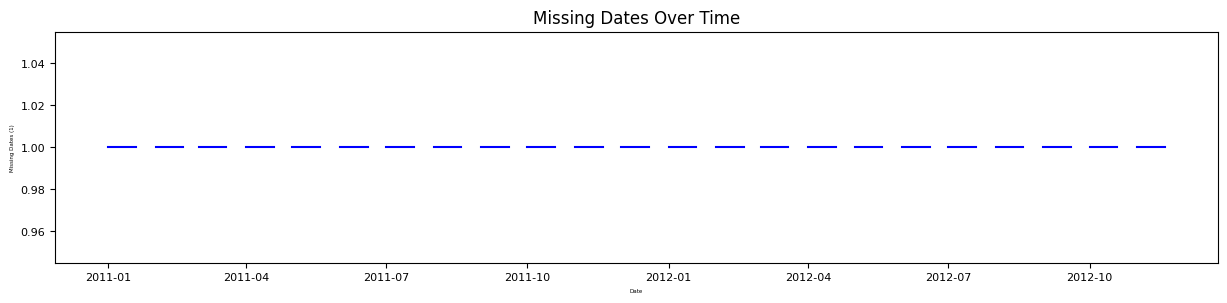

In [110]:
plot_actual_dates(missing_dates_train)

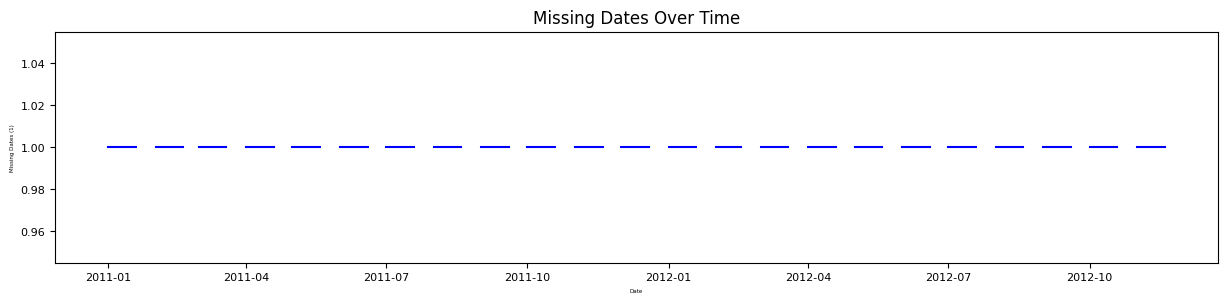

In [111]:
plot_actual_dates(missing_dates_test)

The data we have covers only the first 20 days of each month from January 2011 to November 2012. We don't have information for the other days of each month. Both the Train and Test datasets follow this pattern.

Because of this, using typical time series models or analyses might not be suitable. <br>The Test set shares the same timeframe but includes different hours within each day, keeping only the specific days constant.


**Insights and Comments:**

- <u>Datetime:</u>

    Each timestamp in the 'datetime' column is unique, signifying that there are no duplicated timestamp values. We have separated this column to handle the information individually, extracting details such as:

    * day
    * month
    * year
    * hour

## **Features Analysis**

### Categorical Features distribution

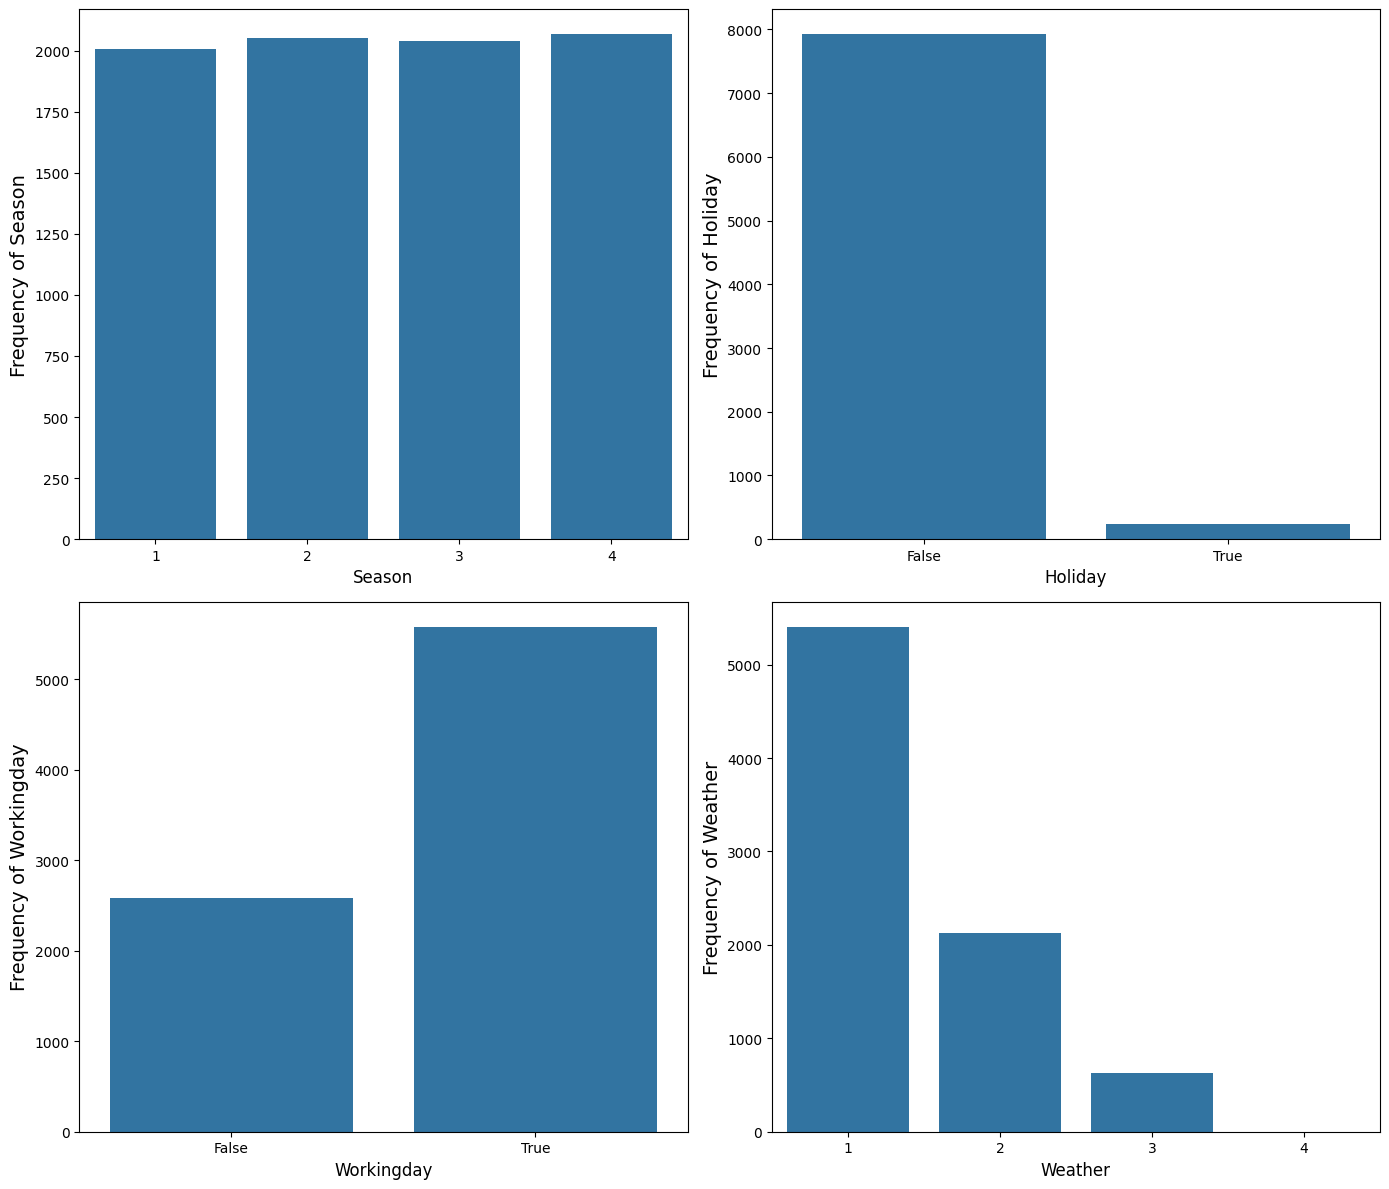

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_categorical_frequency(df, categorical_features):
    num_features = len(categorical_features)

    plt.figure(figsize=(14, 12))

    for i, feature in enumerate(categorical_features, 1):
        plt.subplot(2, 2, i)
        sns.countplot(x=feature, data=df)
        plt.ylabel(f'Frequency of {feature.capitalize()}', fontsize=14)
        plt.xlabel(f'{feature.capitalize()}', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()

categorical_features_list = ['season', 'holiday', 'workingday', 'weather']
plot_categorical_frequency(train_data, categorical_features_list)


**From a first look, we can see that:**
Each count plot has a y-axis label indicating the frequency of the respective categorical feature.
* The 'season' feature has a similar number of instances in the data for every season.
* The majority of instances in the data have clear weather.
* Most of the days in the data are not holidays and possibly workdays.

Let's see the numbers:

In [113]:
def categorial_repr_of_features(df, features):
  for column in features:
      categories = df[column].value_counts()
      print(f"Categories in column '{column}':")
      display(categories)
      # Noting when the categories are unique.
      if len(categories) == df.shape[0]:
          print("Each category is different.")
      print(f"Number of categories: " , len(categories), '\n')

In [114]:
categorial_repr_of_features(train_data, ['holiday', 'workingday', 'season', 'weather'])

Categories in column 'holiday':


False    7924
True      240
Name: holiday, dtype: Int64

Number of categories:  2 

Categories in column 'workingday':


True     5578
False    2586
Name: workingday, dtype: Int64

Number of categories:  2 

Categories in column 'season':


4    2067
2    2051
3    2039
1    2007
Name: season, dtype: int64

Number of categories:  4 

Categories in column 'weather':


1    5406
2    2125
3     632
4       1
Name: weather, dtype: int64

Number of categories:  4 



As we expected, there is an only 1 sample of when the weather is 4.<br>
In addition, for our research it is reasonable to estimate that in this weather the amount of bicycle rentals should decrease significantly.

**Insights and Comments:**

- <u>Season:</u>

    There are four distinct categories in the 'season' column (1, 2, 3, 4) with varying counts.
    The distribution suggests that each season is well-represented in the dataset.


- <u>Holiday and Workingday:</u>

    The 'holiday' column has two categories (0, 1) with the majority being non-holiday days (0).
    The 'workingday' column has two categories (0, 1), with a higher count for working days (1).


- <u>Weather:</u>

    The 'weather' column has four categories (1, 2, 3, 4), with the majority falling under category 1.
    Category 4 appears to have only one occurrence and might be an outlier or error.

###  **Numerical Features Distribution**

Next, we want to observe some statistics to understand what data we have: <br>
(Note that we are only looking at the numerical features and boolean features - which are represented as numbers).

In [115]:
# Get the summary statistics of the features
print("\nSummary statistics of the features:")
train_data.describe()


Summary statistics of the features:


,temp,atemp,humidity,windspeed,pollution,sunlight,traffic
count,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000,8164.000000
mean,20.244980,23.670160,61.835130,12.791334,47.152120,20.245980,0.004986
std,7.796018,8.468725,19.255791,8.213914,72.882602,7.796018,0.006319
min,0.820000,0.760000,0.000000,0.000000,0.000304,0.821000,0.000000
25%,13.940000,16.665000,47.000000,7.001500,3.693188,13.941000,0.000000
50%,20.500000,24.240000,62.000000,12.998000,17.684113,20.501000,0.000242
75%,26.240000,31.060000,77.000000,16.997900,59.257746,26.241000,0.004489
max,41.000000,45.455000,100.000000,56.996900,754.304876,41.001000,0.015615


Based on this information, we can make the following observations: (Generated by GPT)

Here are some conclusions and observations that can be drawn from the train_data dataframe based on the provided statistics:

- <u>Temperature and Apparent Temperature (temp & atemp):</u>

    The mean temperature is around 20.24°C, with a standard deviation of 7.80°C.
    Apparent temperature (atemp) has a similar distribution to temperature.


- <u>Humidity (in %):</u>

    The average humidity is approximately 61.84%, with a standard deviation of 19.26%.
    The minimum humidity is 0%, which might be an outlier or missing data.


- <u>Windspeed:</u>

    The average windspeed is 12.79, with a standard deviation of 8.21.
    There is a wide range of windspeed values, with a minimum of 0 and a maximum of 56.9979.


- <u>Pollution:</u>

    The pollution level has a mean of 47.15, but with a high standard deviation of 72.88.
    The pollution values range from a minimum of 0.000304 to a maximum of 754.30, suggesting potential outliers.


- <u>Sunlight:</u>

    The average sunlight is 20.25, with a standard deviation of 7.80.
    Sunlight values range from a minimum of 0.821 to a maximum of 41.001.
    Seems like it is correlated to temperature...


- <u>Traffic:</u>

    The traffic variable has a very low mean of 0.00499, with a standard deviation of 0.00632.
    The majority of the values seem to be close to zero, suggesting sparse traffic data. Its impact on the bicycle rental demand needs exploration.

Now we would like to understand how the features are structured. <br>
Are the values in each feature repeated ...? What are common values in every feature ...? Is an attribute a representative attribute with different values ...?

In [116]:
categorial_repr_of_features(train_data, numeric_features)


Categories in column 'temp':


14.76    351
26.24    344
18.86    317
28.70    313
22.14    308
13.94    308
22.96    304
24.60    300
12.30    300
27.06    297
25.42    295
16.40    286
29.52    270
13.12    270
21.32    266
17.22    265
10.66    259
20.50    252
18.04    241
30.34    218
9.84     209
15.58    181
9.02     180
31.16    176
8.20     169
27.88    168
32.80    146
23.78    146
11.48    140
19.68    131
6.56     109
33.62     97
5.74      87
7.38      77
31.98     75
35.26     60
34.44     58
4.92      41
36.90     37
4.10      34
37.72     27
36.08     21
3.28       9
38.54      7
0.82       6
39.36      5
2.46       2
1.64       1
41.00      1
Name: temp, dtype: int64

Number of categories:  49 

Categories in column 'atemp':


31.060    506
25.760    325
22.725    317
26.515    304
16.665    292
20.455    286
25.000    269
21.210    265
33.335    261
30.305    256
15.150    256
24.240    252
21.970    241
17.425    232
31.820    228
34.850    217
14.395    207
27.275    205
29.545    204
32.575    204
11.365    194
15.910    191
13.635    189
12.880    183
19.695    181
34.090    160
12.120    157
23.485    131
28.790    125
10.605    119
35.605    118
9.850      98
18.180     94
36.365     93
37.120     92
9.090      78
37.880     75
7.575      59
28.030     59
38.635     55
6.060      49
39.395     46
6.820      46
8.335      41
40.910     34
18.940     33
40.150     31
5.305      20
42.425     20
41.665     18
3.790      11
4.545       8
43.940      6
3.030       6
2.275       6
43.180      6
44.695      2
1.515       1
0.760       1
45.455      1
Name: atemp, dtype: int64

Number of categories:  60 

Categories in column 'humidity':


88.0    292
94.0    238
83.0    227
87.0    215
65.0    197
       ... 
12.0      1
10.0      1
97.0      1
96.0      1
91.0      1
Name: humidity, Length: 87, dtype: int64

Number of categories:  87 

Categories in column 'windspeed':


0.0000     1000
11.0014     819
8.9981      816
12.9980     783
7.0015      753
15.0013     693
6.0032      675
16.9979     632
19.0012     504
19.9995     359
22.0028     283
23.9994     200
26.0027     174
27.9993     148
30.0026      81
31.0009      69
32.9975      59
35.0008      46
39.0007      21
36.9974      19
40.9973       9
43.9989       7
43.0006       7
56.9969       2
47.9988       2
51.9987       1
50.0021       1
46.0022       1
Name: windspeed, dtype: int64

Number of categories:  28 

Categories in column 'pollution':


10.820673     1
8.869671      1
14.358392     1
24.787544     1
408.938695    1
             ..
6.440203      1
0.004325      1
25.114585     1
41.748096     1
49.855590     1
Name: pollution, Length: 8164, dtype: int64

Each category is different.
Number of categories:  8164 

Categories in column 'sunlight':


14.761    351
26.241    344
18.861    317
28.701    313
22.141    308
13.941    308
22.961    304
24.601    300
12.301    300
27.061    297
25.421    295
16.401    286
29.521    270
13.121    270
21.321    266
17.221    265
10.661    259
20.501    252
18.041    241
30.341    218
9.841     209
15.581    181
9.021     180
31.161    176
8.201     169
27.881    168
32.801    146
23.781    146
11.481    140
19.681    131
6.561     109
33.621     97
5.741      87
7.381      77
31.981     75
35.261     60
34.441     58
4.921      41
36.901     37
4.101      34
37.721     27
36.081     21
3.281       9
38.541      7
0.821       6
39.361      5
2.461       2
1.641       1
41.001      1
Name: sunlight, dtype: int64

Number of categories:  49 

Categories in column 'traffic':


0.000000    2090
0.000242    2088
0.015615    2005
0.004489    1981
Name: traffic, dtype: int64

Number of categories:  4 



**Insights and Comments:**

- <u>Temperature and Apparent Temperature (temp, atemp):</u>

    Both 'temp' and 'atemp' columns have a wide range of values, with multiple occurrences for each temperature.
    These features appear to have been discretized or rounded, resulting in multiple instances of the same temperature.


- <u>Humidity:</u>

    The 'humidity' column has 87 unique values, indicating a diverse range of humidity levels in the dataset.


- <u>Windspeed:</u>

    The 'windspeed' column has 29 unique values, with a dominant occurrence of 0.0000.
    It's possible that the windspeed values have been discretized, and 0.0000 might represent calm or very low windspeed.


- <u>Pollution:</u>

    Each value in the 'pollution' column is unique, indicating a diverse range of pollution levels.
    This feature appears to be continuous and might require further investigation for outliers.


- <u>Sunlight:</u>

    Similar to 'temp' and 'atemp', the 'sunlight' column has a variety of values with multiple occurrences for each sunlight level.


- <u>Traffic:</u>

    The 'traffic' column has four distinct values, with the majority being either 0.000000 or 0.000242.
    This variable might represent traffic intensity, and the low values suggest sparse traffic data. <br>
    Moreover, it behaves like a categorical variable with only 4 possible values - STRANGE. <br>
    Also, the numbers are very low and very close to 0.

Let's take a look on the distribution of the numerical features to draw some conclusions:

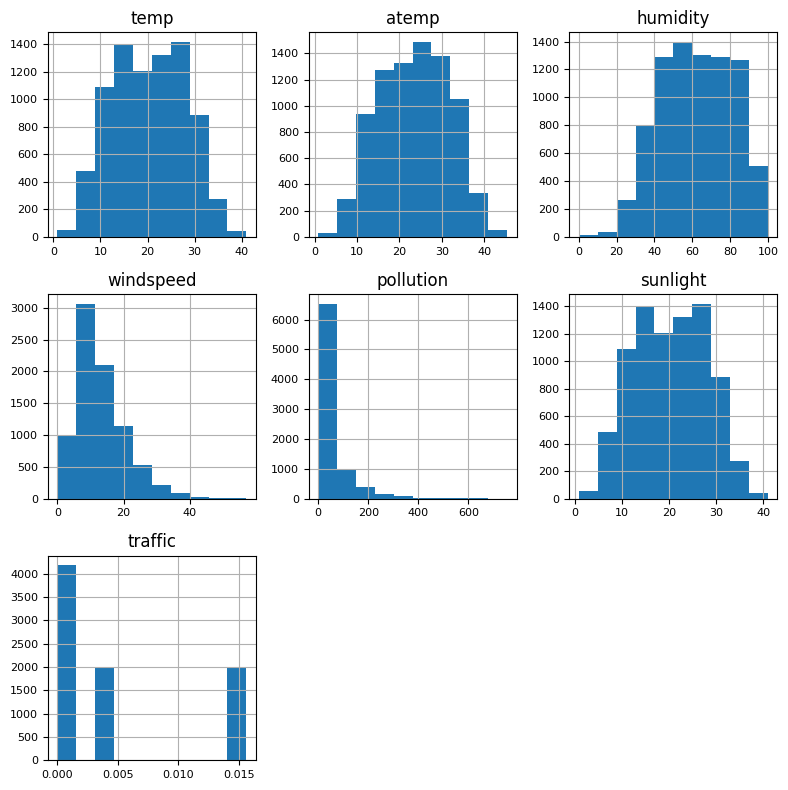

In [117]:
plt.figure(figsize=(8, 8))
plt.rc('axes', labelsize=4)  # Adjust label font size
plt.rc('xtick', labelsize=8)  # Adjust x-axis tick font size
plt.rc('ytick', labelsize=8)  # Adjust y-axis tick font size
plt.rc('legend', fontsize=8)  # Adjust legend font size

train_data_subset = train_data.drop(columns=['datetime'])

# Plot histograms
train_data_subset.hist(ax=plt.gca())
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

* Seems that there might be some outliers in "windspeed" and "pollution" as stated above.

**Another look:**

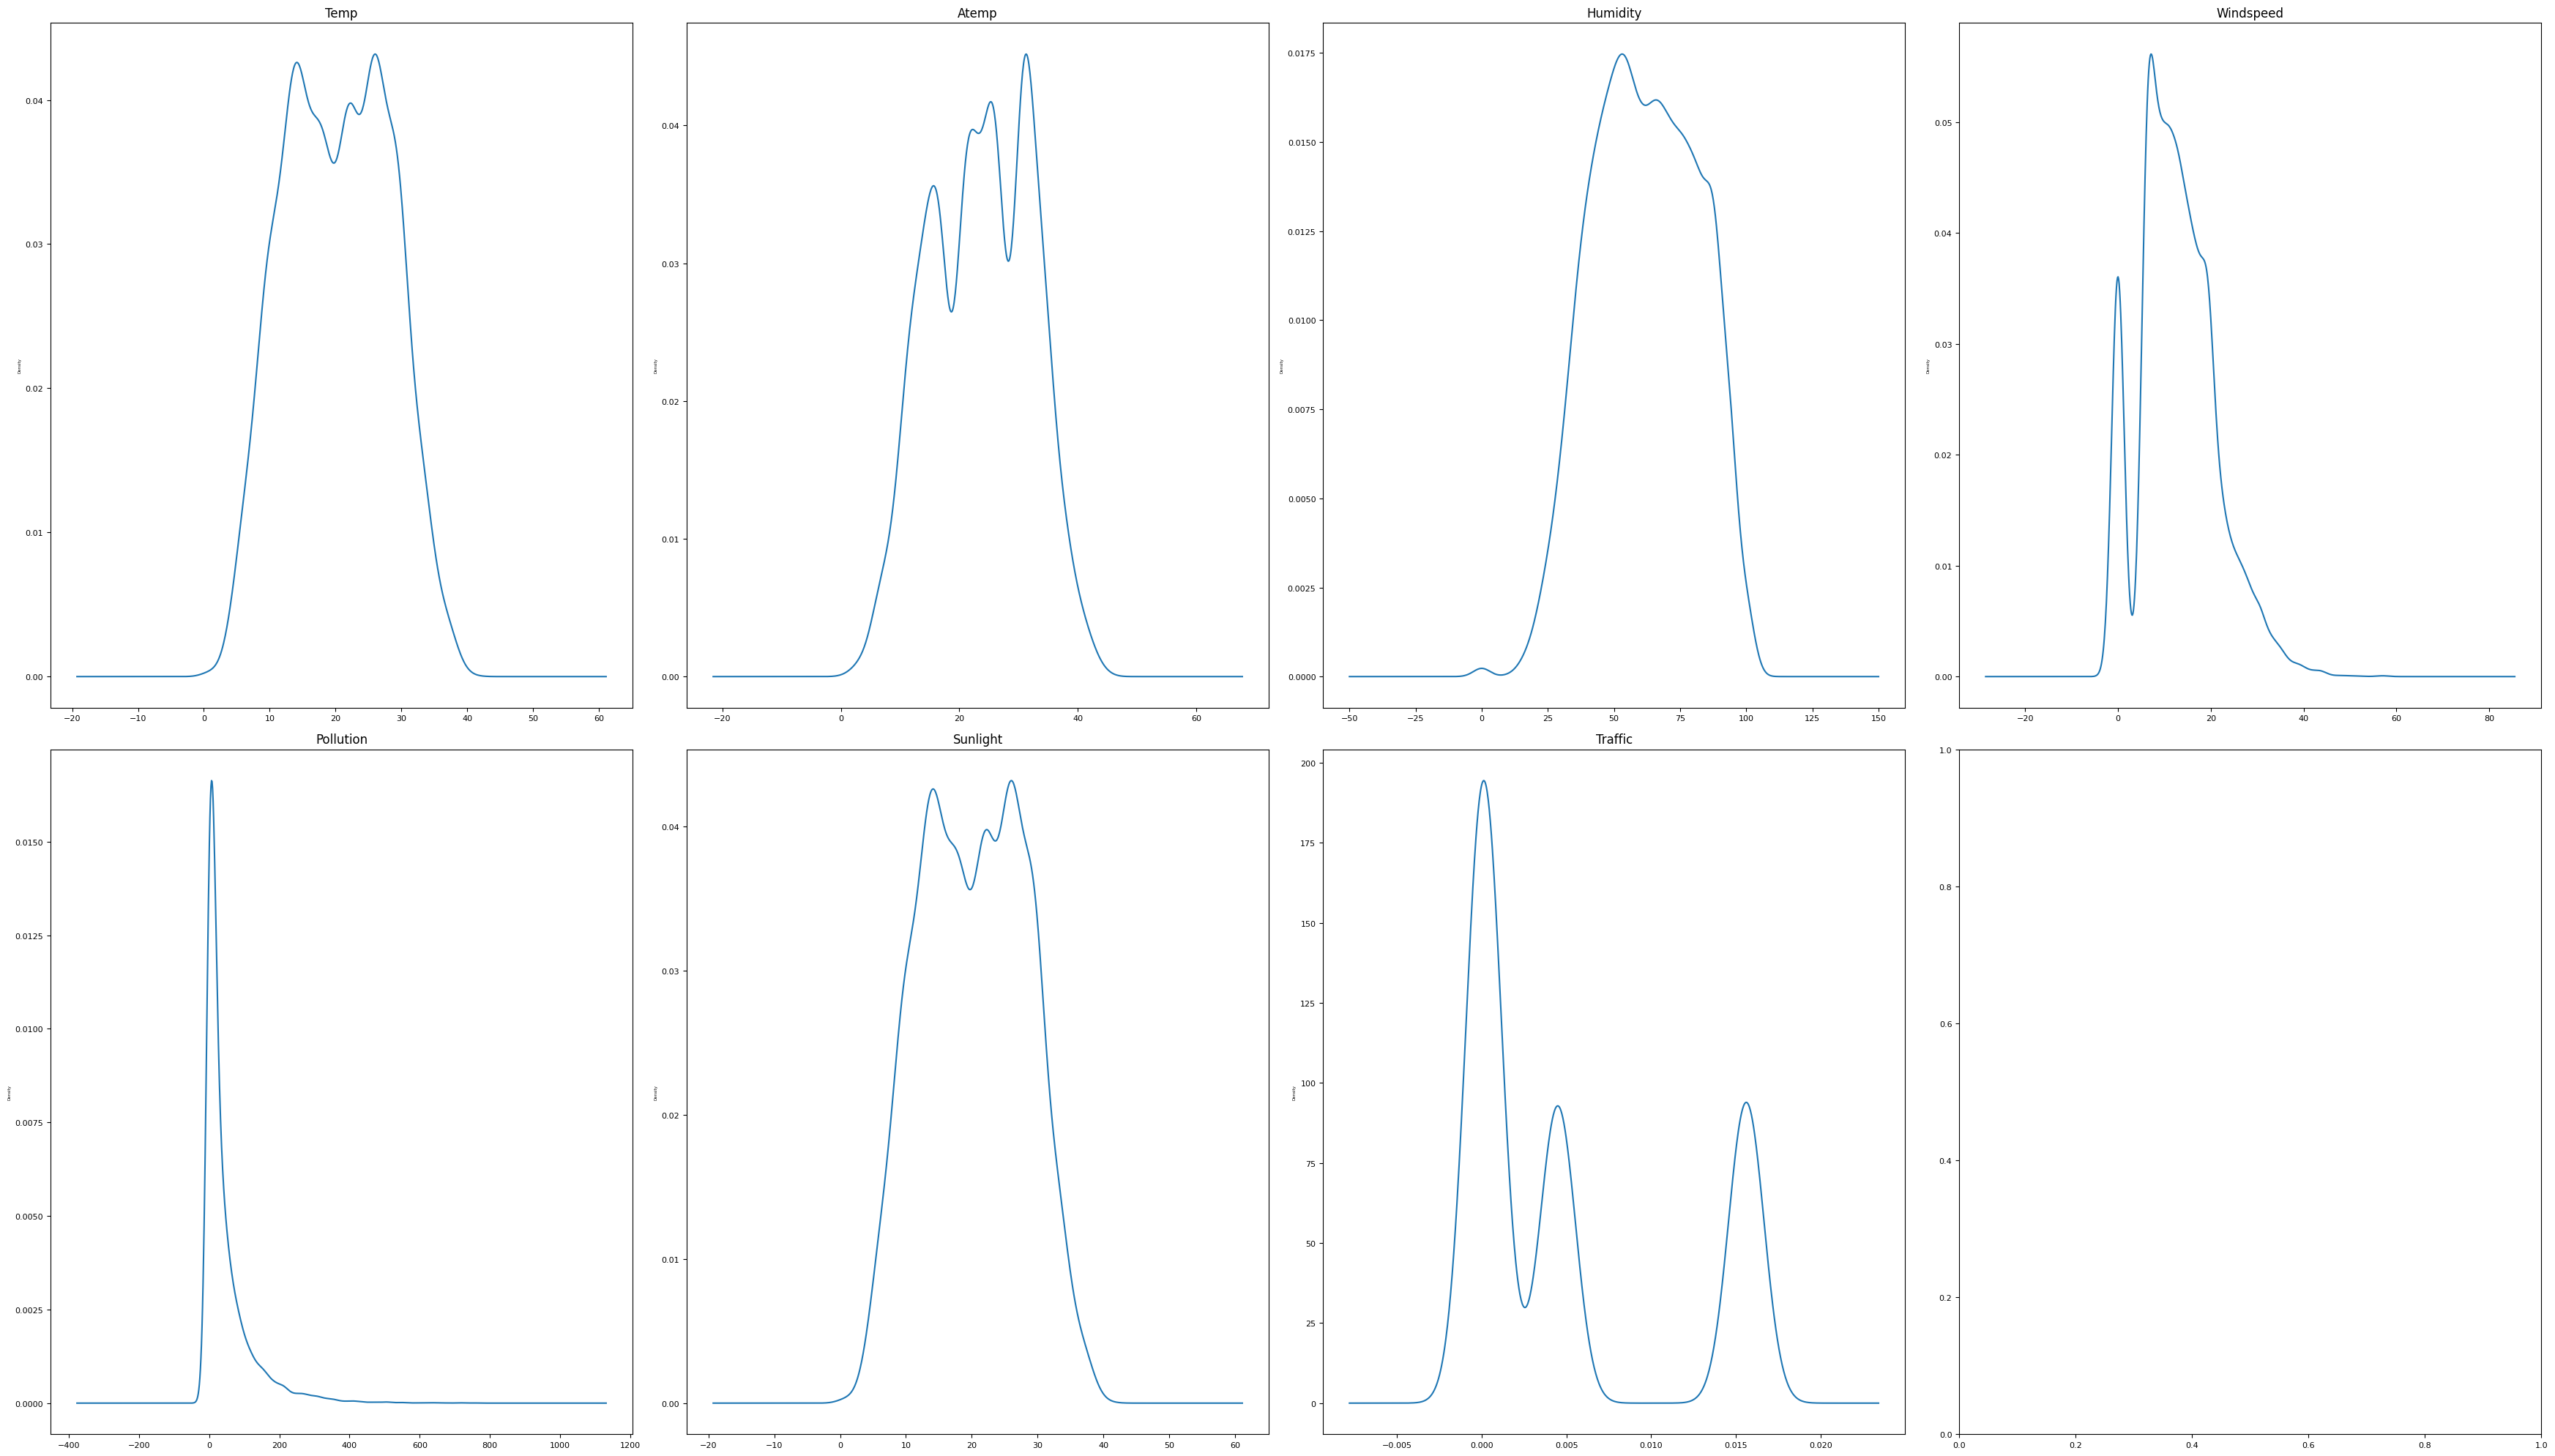

In [118]:
def create_distribution_graph(df):
    numeric_cols = df.select_dtypes(include=[float, int]).columns
    num_cols = len(numeric_cols)
    rows = int(math.sqrt(num_cols))
    cols = int(math.ceil(num_cols / rows))

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(35, 20))

    plot_index = 0
    for i in range(rows):
        for j in range(cols):
            if plot_index < num_cols:
                col = numeric_cols[plot_index]
                df[col].plot.density(ax=axes[i, j])
                axes[i, j].set_title(col.capitalize())
                plot_index += 1

    plt.tight_layout()
    plt.show()

create_distribution_graph(train_data)

* "Humidity" and "Pollution" show some type of normality, maybe after some tweaking a better conclusion could be drawn.

We will deal with outliers later.<br>
Hence, let's apply log transformation on these features:

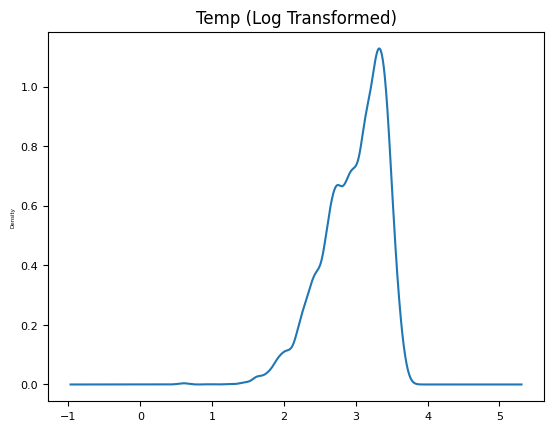

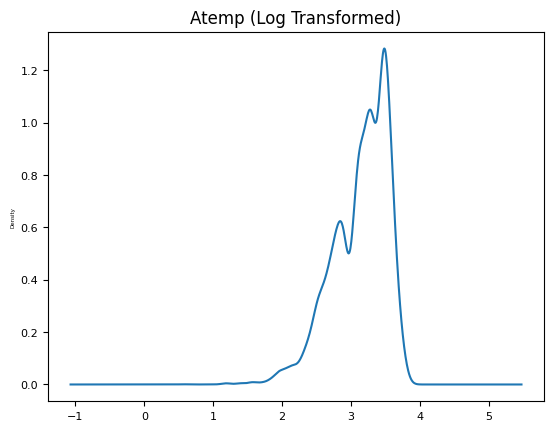

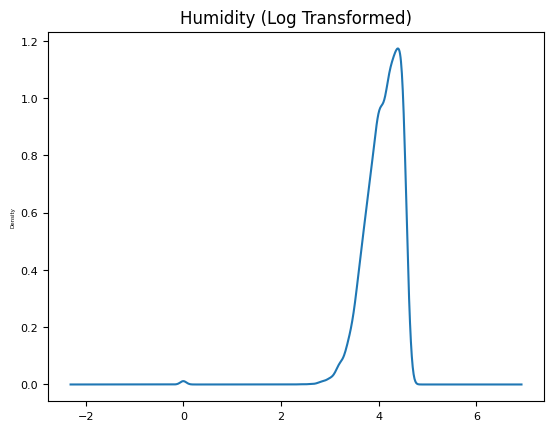

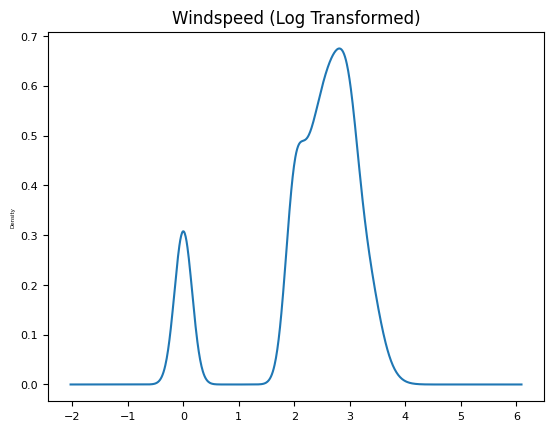

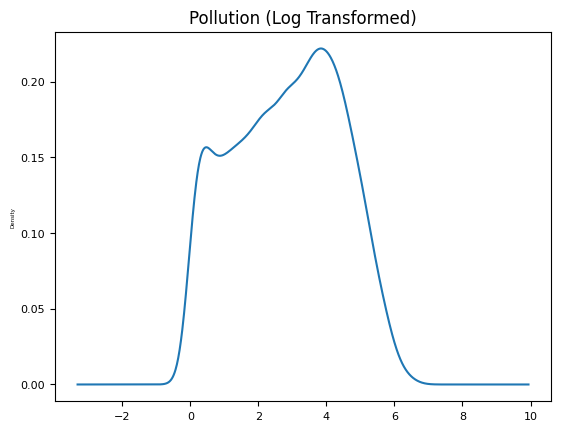

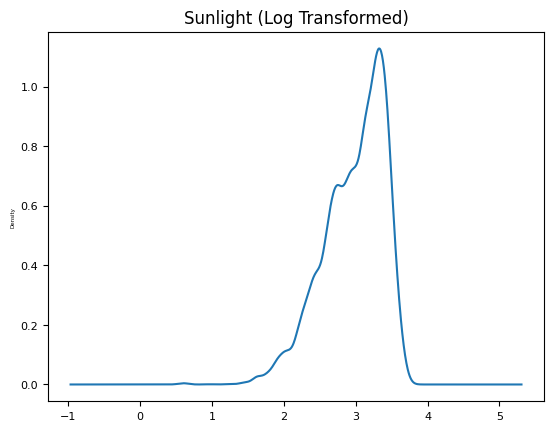

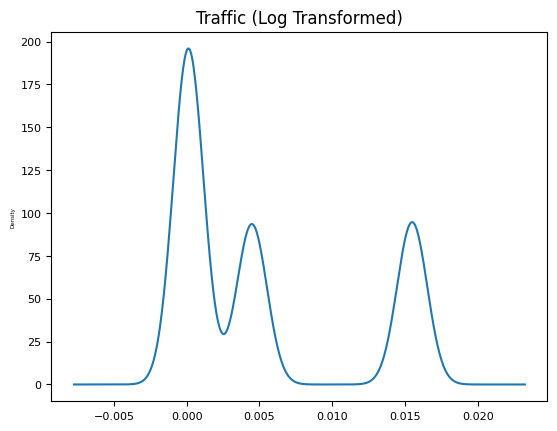

In [119]:
# Function that creates a distribution graph for all the numeric features
def create_distribution_graph(df):
    for i, col in enumerate(df.select_dtypes(include=[float, int])):
        transformed_data = np.log1p(df[col])  # Apply logarithm transformation
        transformed_data.plot.density()
        plt.title(col.capitalize() + " (Log Transformed)")
        plt.show()

create_distribution_graph(train_data)

* It can be seen that some features appear to follow a normal distribution (or something close enough) like: humidity and log of temp and log of sunlight.
* the distrdistribution of temp and sunlight look the same.

## **Label Analysis**

In [120]:
train_with_labels

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,count,day,month,year,hour
6560,2011-01-01 01:00:00,1,False,False,1,9.02,13.635,80.0,0.0000,10.820673,9.021,0.000000,40,1,1,2011,1
3754,2011-01-01 02:00:00,1,False,False,1,9.02,13.635,80.0,0.0000,19.189498,9.021,0.004489,32,1,1,2011,2
7767,2011-01-01 04:00:00,1,False,False,1,9.84,14.395,75.0,0.0000,0.133472,9.841,0.015615,1,1,1,2011,4
7272,2011-01-01 05:00:00,1,False,False,2,9.84,12.880,75.0,6.0032,0.014335,9.841,0.000000,1,1,1,2011,5
5381,2011-01-01 06:00:00,1,False,False,1,9.02,13.635,80.0,0.0000,0.096936,9.021,0.004489,2,1,1,2011,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4763,2012-12-19 16:00:00,4,False,True,1,17.22,21.210,50.0,23.9994,19.956957,17.221,0.015615,334,19,12,2012,16
467,2012-12-19 18:00:00,4,False,True,1,15.58,19.695,50.0,23.9994,212.578827,15.581,0.004489,569,19,12,2012,18
4423,2012-12-19 19:00:00,4,False,True,1,15.58,19.695,50.0,26.0027,21.027171,15.581,0.015615,336,19,12,2012,19
3307,2012-12-19 20:00:00,4,False,True,1,14.76,17.425,57.0,15.0013,37.737255,14.761,0.004489,241,19,12,2012,20


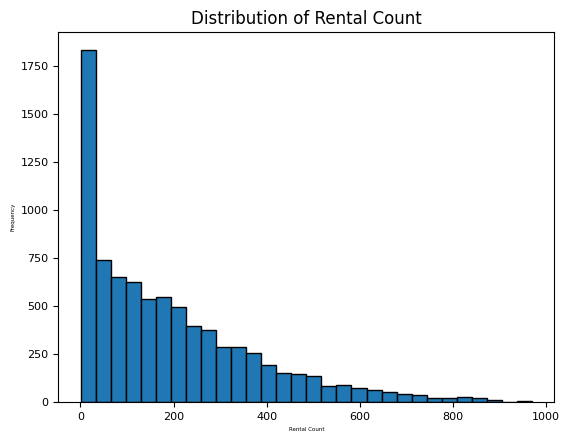

In [121]:
plt.hist(train_with_labels['count'], bins=30, edgecolor='black')
plt.title('Distribution of Rental Count')
plt.xlabel('Rental Count')
plt.ylabel('Frequency')
plt.show()

In this chart we can see how many times there was any amount of bike rentals. For example, there were more than 1750 times (hours) where there were 0 bike rentals.

**Box Plot for Target Variable vs. Categorical and Boolean Features to explore how the target variable varies across different categories:**

Let's see some information about the count of the bike rentals there were in each category:

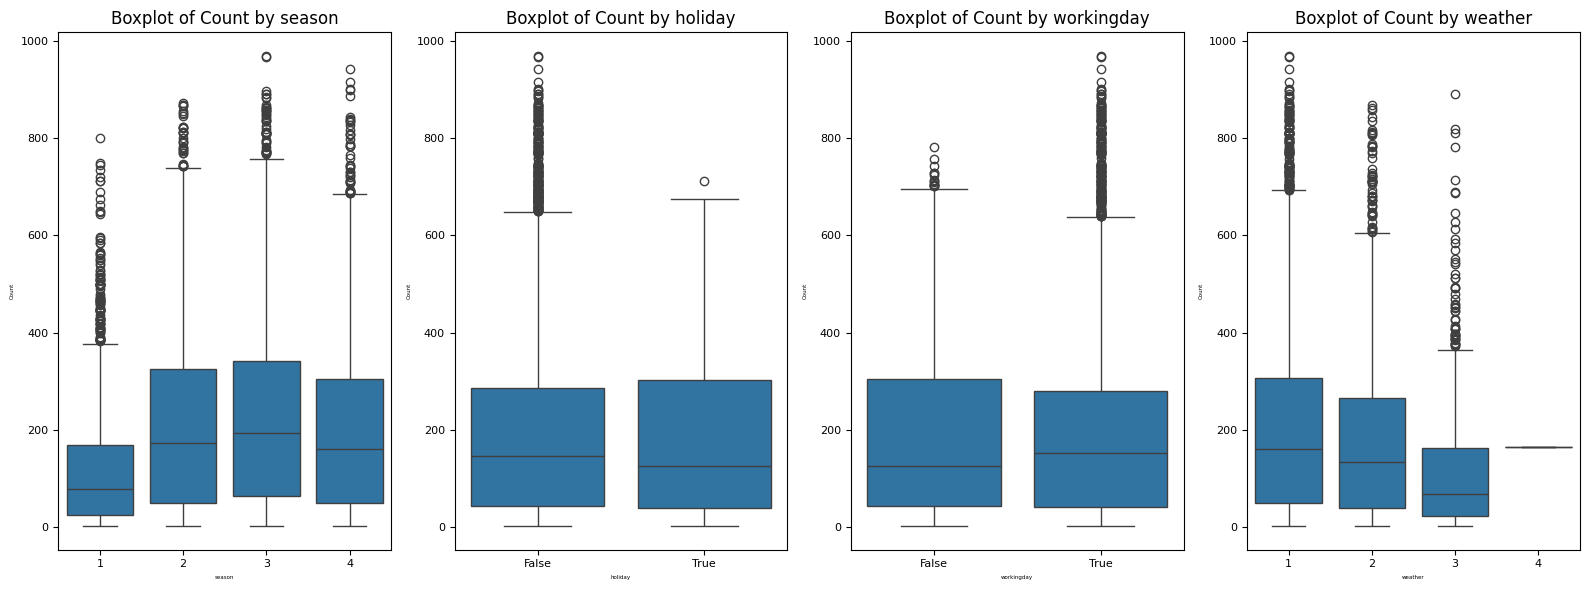

In [122]:
# Box Plot for Target Variable vs. Categorical and Boolean Features to explore how the target variable varies across different categories.
categorical_features = ['season', 'holiday', 'workingday', 'weather']
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(16, 6))
for i, feature in enumerate(categorical_features):
    sns.boxplot(x=feature, y='count', data=train_with_labels, ax=axes[i])
    axes[i].set_title(f'Boxplot of Count by {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

We can understand things about the median and the percentiles of the amount of bike rentals in each category.

Let's analyze the distribution of bike rentals across distinct categories within specific categorical features ('season,' 'holiday,' 'workingday,' and 'weather').

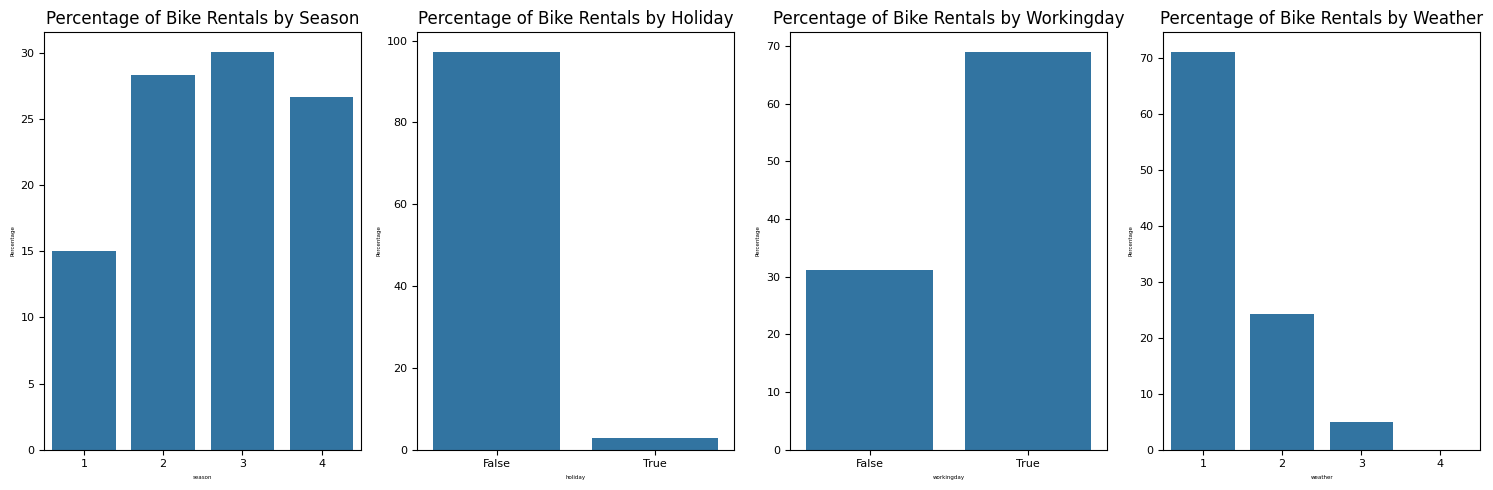

In [123]:
# Calculate the total count of bike rentals
total_rentals = train_with_labels['count'].sum()

# List of categorical features
categorical_features = ['season', 'holiday', 'workingday', 'weather']

# Create subplots with a single row and multiple columns
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(15, 5))

# Iterate over each categorical feature
for i, feature in enumerate(categorical_features):
    # Calculate the percentage of bike rentals for each category
    percentages = (train_with_labels.groupby(feature)['count'].sum() / total_rentals) * 100

    # Create a bar plot for each categorical feature
    sns.barplot(x=percentages.index, y=percentages, ax=axes[i])
    axes[i].set_title(f'Percentage of Bike Rentals by {feature.capitalize()}')
    axes[i].set_ylabel('Percentage')

# Adjust the layout
plt.tight_layout()
plt.show()



These charts calculate the percentage of bike rentals for each category. <br>For example, only 15 percent of the bike rentals happened in season 1.<br>
An overwhelming majority of the bike rentals happened on weekdays and not on holidays.<br>

It is difficult to draw conclusions from these data due to the imbalance in the data. We will have difficulty understanding the behavior of the bicycle rentals in each of the categories due to the imbalance in the data and we would like to normalize this data in order to better study the nature of the bicycle rentals. For example, there are many more weekdays than holidays - the data will be skewed so that naturally more bikes will be rented on weekdays because there are more weekdays in the data.


In [124]:
total_bike_rentals = train_with_labels['count'].sum()

print(f"Total number of bike rentals in the dataset: {total_bike_rentals}")

Total number of bike rentals in the dataset: 1562098


In [125]:
# List of categorical features
categorical_features = ['season', 'weather', 'holiday', 'workingday']

# Loop through each categorical feature
for feature in categorical_features:
    # Calculate the sum of rental bikes for each category
    total_count_by_category = train_with_labels.groupby(feature)['count'].sum()

    # Print the results
    print(f"Total rental bikes by {feature}:")
    print(total_count_by_category)
    print("\n" + "-"*30 + "\n")

Total rental bikes by season:
season
1    234986
2    441917
3    469182
4    416013
Name: count, dtype: int64

------------------------------

Total rental bikes by weather:
weather
1    1108664
2     377331
3      75939
4        164
Name: count, dtype: int64

------------------------------

Total rental bikes by holiday:
holiday
False    1517865
True       44233
Name: count, dtype: int64

------------------------------

Total rental bikes by workingday:
workingday
False     485715
True     1076383
Name: count, dtype: int64

------------------------------



To address the imbalance in the data and provide a fair comparison across categories, we toke the sum of bike rentals and divided it by the amount of each category instance. then we got the average count of rentals per unit in every categorial feature. This way, we normalized the rental counts by the frequency of each category.


This code calculates the mean number of rental bikes for each category within the specified categorical features:

In [126]:
# List of categorical features
categorical_features = ['season', 'weather', 'holiday', 'workingday', 'day']

# Loop through each categorical feature
for feature in categorical_features:
    # Calculate the mean number of rental bikes for each category
    mean_count_by_category = train_with_labels.groupby(feature)['count'].mean()

    # Print the results
    print(f"Mean rental bikes by {feature}:")
    print(mean_count_by_category)
    print("\n" + "-"*30 + "\n")

Mean rental bikes by season:
season
1    117.083209
2    215.464164
3    230.103973
4    201.264151
Name: count, dtype: float64

------------------------------

Mean rental bikes by weather:
weather
1    205.080281
2    177.567529
3    120.156646
4    164.000000
Name: count, dtype: float64

------------------------------

Mean rental bikes by holiday:
holiday
False    191.552877
True     184.304167
Name: count, dtype: float64

------------------------------

Mean rental bikes by workingday:
workingday
False    187.824826
True     192.969344
Name: count, dtype: float64

------------------------------

Mean rental bikes by day:
day
1     177.188095
2     184.524775
3     195.112941
4     191.816934
5     194.096330
6     195.444700
7     181.874429
8     183.600928
9     186.637931
10    194.070258
11    189.514943
12    189.366029
13    194.527316
14    193.424460
15    205.395181
16    180.199531
17    209.624703
18    198.258294
19    192.203233
Name: count, dtype: float64

----------

This code creates a set of pie charts to visualize the mean number of rental bikes for each category within the specified categorical features:

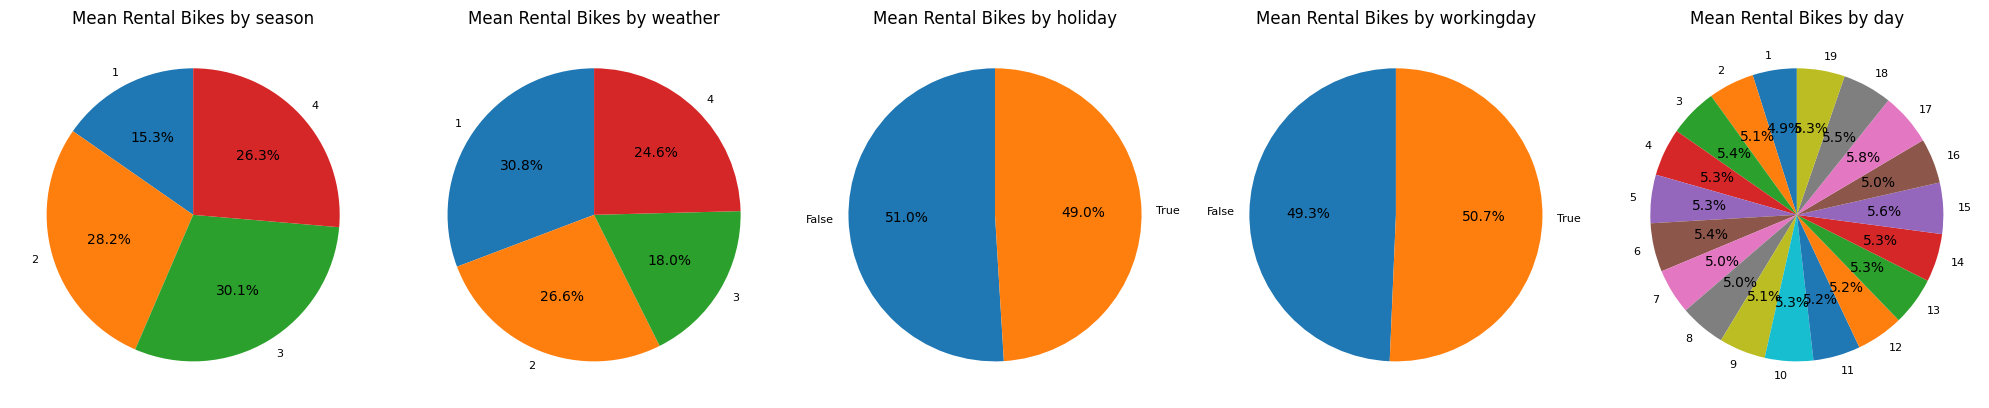

In [127]:
# List of categorical features
categorical_features = ['season', 'weather', 'holiday', 'workingday', 'day']

# Set up subplots
fig, axes = plt.subplots(1, len(categorical_features), figsize=(20, 6))

# Loop through each categorical feature
for i, feature in enumerate(categorical_features):
    # Calculate the mean number of rental bikes for each category
    mean_count_by_category = train_with_labels.groupby(feature)['count'].mean()

    # Plot the means in a pie chart
    axes[i].pie(mean_count_by_category, labels=mean_count_by_category.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"Mean Rental Bikes by {feature}")

# Adjust layout
plt.tight_layout()
plt.show()

**From the visualization above, we get the following insights:**

* **Season:**
Rentals tend to be lower in Season 1 (Spring) compared to the other seasons.
Season 3 (Fall) has the highest mean rental count.

* **Weather:**
Weather conditions 1 (Clear, Few clouds) have the highest mean rental count.
Weather condition 3 (Light Snow, Light Rain, Thunderstorm) has the lowest mean rental count.


* **Holiday:**
There is a slight decrease in mean rental count on holidays compared to non-holidays, but the difference is not very significant.

* **Workingday:**
Mean rental counts are slightly higher on working days compared to non-working days.<br><br>


 The insights offer an overview of average rental counts across various categorical features. It seems that factors such as season and weather exert more noticeable effects on rental counts compared to holiday or working day status. Overall, although there are some variations in mean rental counts across different feature categories, **the differences may not be highly significant.**

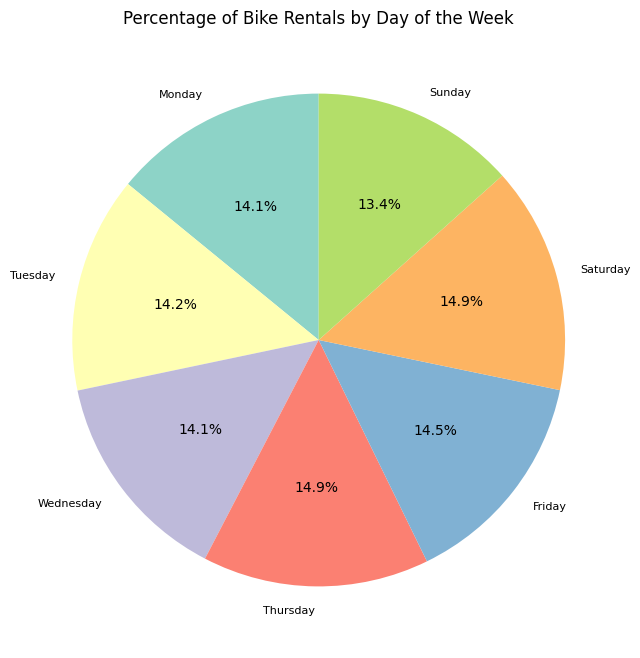

In [128]:
#This code calculates and plots the percentage of bike rentals by day of the week.

total_counts_by_day = train_with_labels.groupby(train_with_labels['datetime'].dt.dayofweek)['count'].sum()
percentage_rentals_by_day = (total_counts_by_day / total_counts_by_day.sum()) * 100

days_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8, 8))
plt.pie(percentage_rentals_by_day, labels=days_labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Percentage of Bike Rentals by Day of the Week')
plt.show()


From the visualization above of the bike rental percentages for each day, we observe a consistent pattern throughout the week. The rental percentage remains relatively stable at between 14.1% and 14.9% for each day, except for Sunday, where it slightly decreases to 13.4%. This slight deviation aligns with expectations as Sunday is typically a non-working day. But we consider the variation as minimal, so we could say it is a fairly uniform distribution of bike rentals across the days of the week, with Sunday being only marginally lower but still in close proximity to the 14% mark observed on other days.

## Correlation

**trying to learn about the relationships between numerical features and the target variable using a correlation matrix**

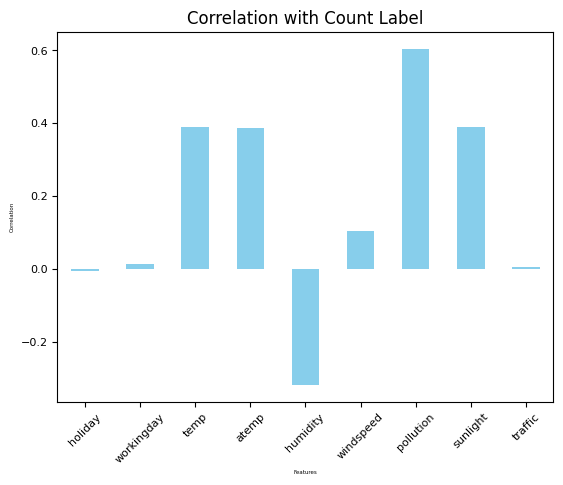

In [129]:
plt.figure()
correlation_matrix = train_with_labels.corr()
correlation_with_label = correlation_matrix['count']

# Remove the label feature from the correlation
correlation_with_label = correlation_with_label.drop('count')

correlation_with_label.plot(kind='bar', color='skyblue')
plt.title('Correlation with Count Label')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()

**Insights from the presentation of the correlation:**

*  The correlation tables provide insights into the relationships between variables in a dataset, especially focusing on how variables are associated with each other and, in the case of the second table, their correlation with a specific target variable ('count').
*   'polution' feature is highly correlated with the label (0.6), that is, it can be concluded that as air pollution increases, there are more bike rentals and vice versa.
*   'traffic' has a very low correlation with both the target variable ('count') and other features.


Let's make a full correlation matrix:

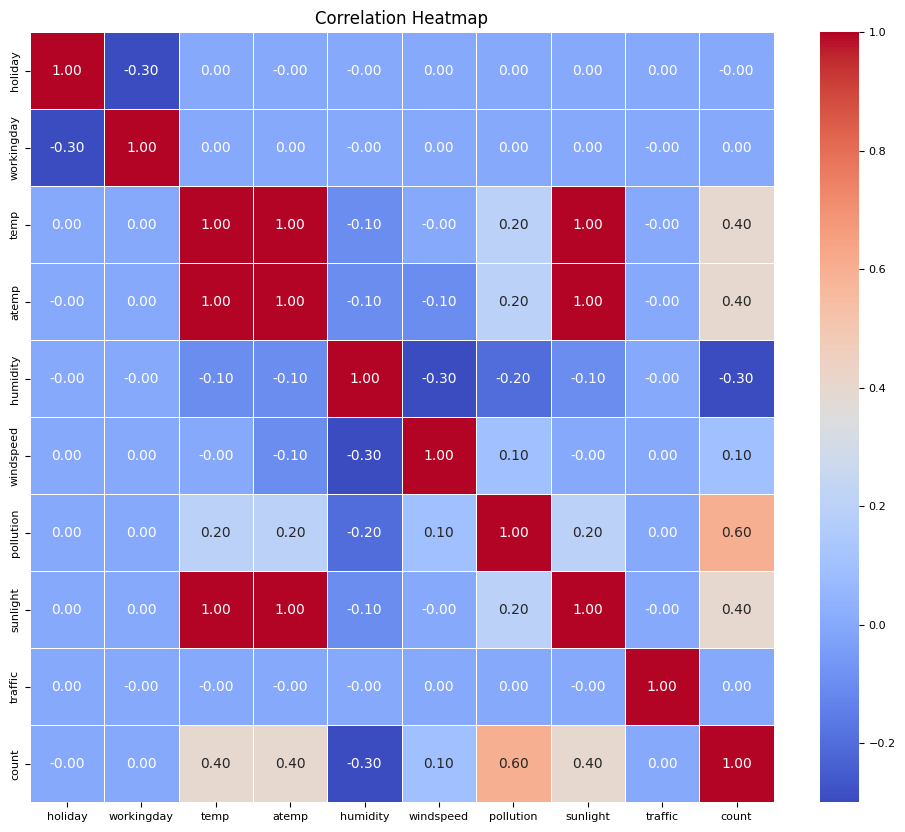

In [130]:
def corr_matrix(df):
  corr_matrix = df.corr().round(1)  # Round the correlation values to 1 decimal place
  plt.figure(figsize=(12, 10))
  sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)  # Set fmt='.1f' to display 1 decimal place
  plt.title('Correlation Heatmap')
  plt.show()

corr_matrix(train_with_labels)

This function creates a visual representation of the correlation matrix using a color-coded heatmap.<br>
It displays a grid of squares, where each square represents the correlation between two features.

Here are some general observations we can make from the heatmap:

<b> Strong positive correlation:</b> If two features have a high positive correlation, it suggests that as one feature increases, the other feature tends to increase as well. Conversely, if two features have a strong negative correlation (close to -1), it means that as one feature increases, the other feature tends to decrease.

<b>Weak or no correlation:</b> If the correlation coefficient is close to 0, it indicates a weak or no linear relationship between the features. This means that changes in one feature do not necessarily correspond to changes in the other feature.

<b>Redundant or highly correlated features:</b> High correlation values between pairs of features might indicate that these features provide similar information, in our case: sunlight & temp & atemp. Sunlight, temperature, and average temperature (atemp) show multicollinearity because they're closely related in weather patterns. Clear and sunny days typically come with both higher temperatures, making these variables correlated and potentially redundant in predicting outcomes.


**Insights from the correlation matrix:**

* As we saw before, the label "count" is highly correlated with the feature "pollution" (0.6).
* Correlation of 0.4 (not too low) with: temp, atemp, sunlight with count.
* We will observe that there are also numerous instances of zeros, indicating an absolute absence of correlation.
* We can see that there is high correlation (1) between the features "temp", "atemp" and "sunlight".

**VIF:**

Let's take a look in general. <br>
In this part we will use a new method which was not learnt in class- the VIF method.
We want primarily observe whether a feature has a high correlation with other features based on its Variance Inflation Factor (VIF) value.<br>
A high VIF value indicates multicollinearity, which suggests a strong correlation between the feature and other features in the dataset.

In [131]:
# Select numerical features (excluding the categorical features)
numerical_features = train_data.select_dtypes(include=['float64', 'bool'])

# Convert boolean features to numeric (0 and 1)
boolean_features = numerical_features.select_dtypes(include='bool')
boolean_features = numerical_features.dropna()
numerical_features[boolean_features.columns] = boolean_features.astype(int)

# Remove any rows with null values in the selected features
numerical_features = numerical_features.dropna()

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = numerical_features.columns
vif["VIF"] = [variance_inflation_factor(numerical_features.values.astype(float), i) for i in range(numerical_features.shape[1])]

print("VIF for all features except category features:")
print(vif)

VIF for all features except category features:
     Variable         VIF
0     holiday    1.093512
1  workingday    3.142565
2        temp         inf
3       atemp  256.536128
4    humidity    6.189755
5   windspeed    2.765785
6   pollution    1.528149
7    sunlight         inf
8     traffic         NaN


To calculate the VIF, we regress each predictor variable against all the other predictor variables in the model. The VIF for each variable is then computed as the ratio of the variance of the estimated regression coefficient to the variance of the coefficient if that variable was uncorrelated with the other predictors.

Features with VIF values close to 1 (around or below 1) indicate low multicollinearity. These features are relatively independent of each other when predicting the target variable.<br>
Examples: None.<br>

Features with VIF values between 1 and 5 are generally considered to have moderate multicollinearity. Although there might be some correlation, it is not severe.<br>
Examples: "holiday", "workingday", "windspeed", "pollution".<br>

Features with VIF values above 5 suggest the presence of multicollinearity. These features have a strong correlation with other features in the dataset and may negatively impact the model's performance.<br>
Examples: "temp", "atemp", "humidity", "sunlight".
<br><br>
Based on this information, we can consider the VIF values to identify potential issues related to multicollinearity.<br>
 High VIF values indicate that certain features are highly correlated with others, which can affect the model's interpretability and stability.<br>
In such cases, we may consider removing or transforming the highly correlated features to mitigate multicollinearity and improve the model's performance.

**The feature "traffic" again doing some problems outputting NAN. We will consider removing it because it is behaving abnormally.**




In conclusion, the VIF index helped us to understand in general whether there is a correlation for features.
The correlation matrix looked linearly at whether there was a correlation between each 2 features.
In both of these indices we saw that the "temp", "atemp" and "sunlight" features has a very high correlation.
**All in all, later, we will maybe consider dropping some of them to improve the model.**

## Missing Values

We will check the amount of NULL valuse (We can see that there are no null values):

In [132]:
train_data.isnull().sum().sort_values(ascending = False)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
pollution     0
sunlight      0
traffic       0
day           0
month         0
year          0
hour          0
dtype: int64

There is no need to handle missing values in the pre-process due to no null values as we can see above.


## Outliers Visualization

In order to identify potential outliers,
lets visualize, as a start, the boxplots of each non-categorial feature:

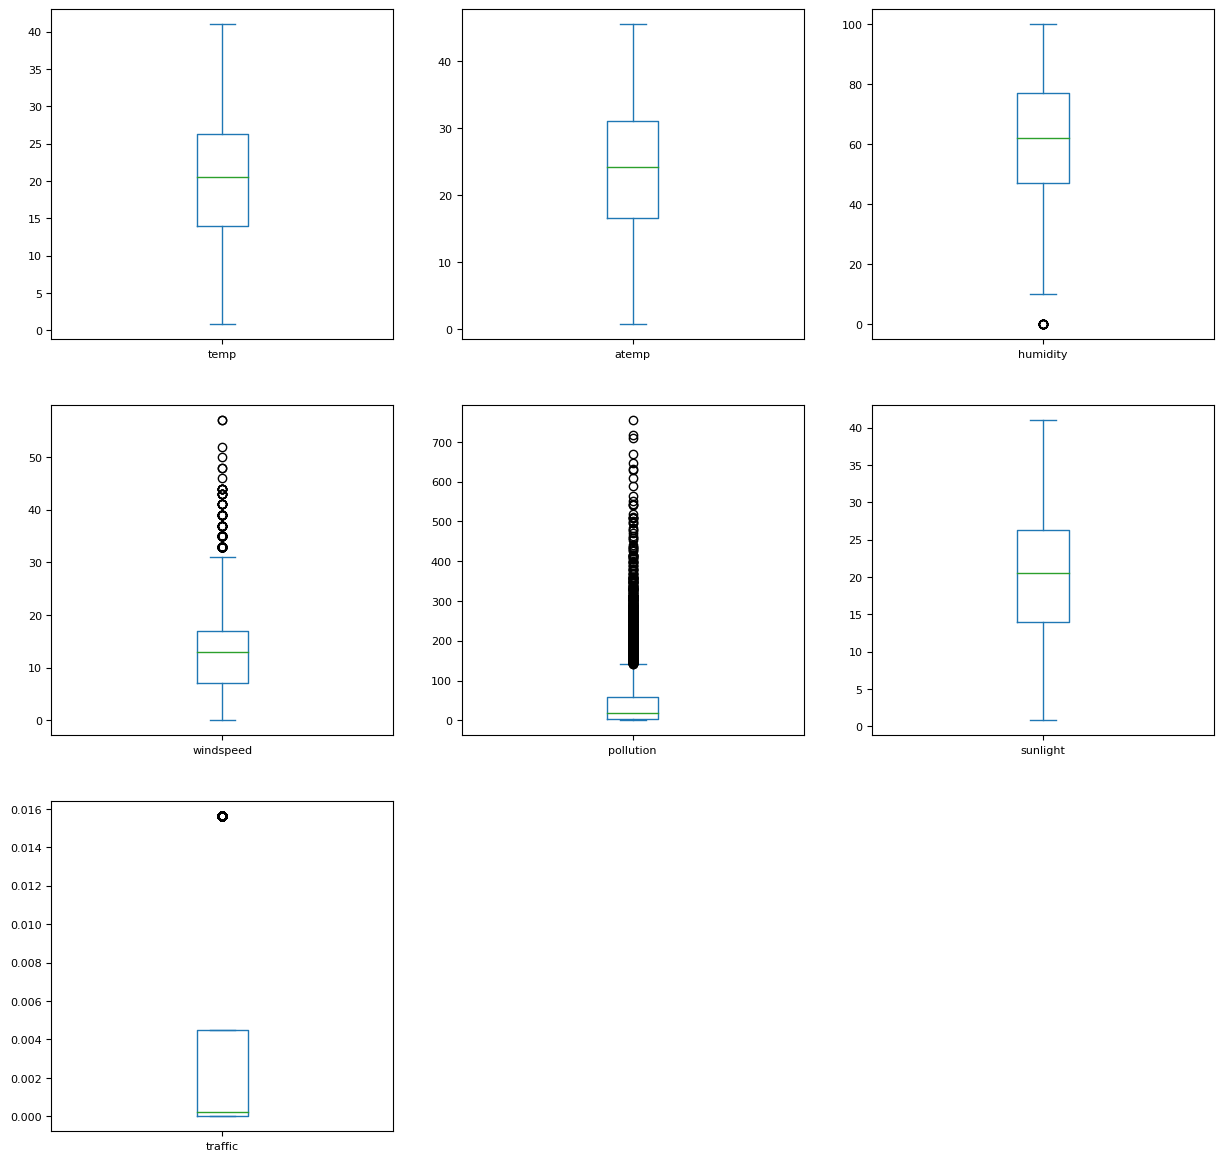

In [133]:
train_data.plot(kind="box",subplots=True,layout=(6,3),figsize=(15,30));

In general, from boxplots we can see outliers and the distribution of features.
We can see that 'temp', 'atemp', 'humidity', 'windspeed' and 'sunlight' are normally distributed.

Also, seems like 'pollution' has a lot of outliers and 'windspeed' has some less outliers.

Log transformation compresses the range of the variable. In other words, it brings large values closer together and spreads out small values. This compression can help reduce the influence of extreme values.

Also, log transformation can make the distribution of a variable more symmetric. In many cases, taking the logarithm can pull the outliers back towards the center.

So, before getting to final conclusions, lets see the log-boxplots of these features:


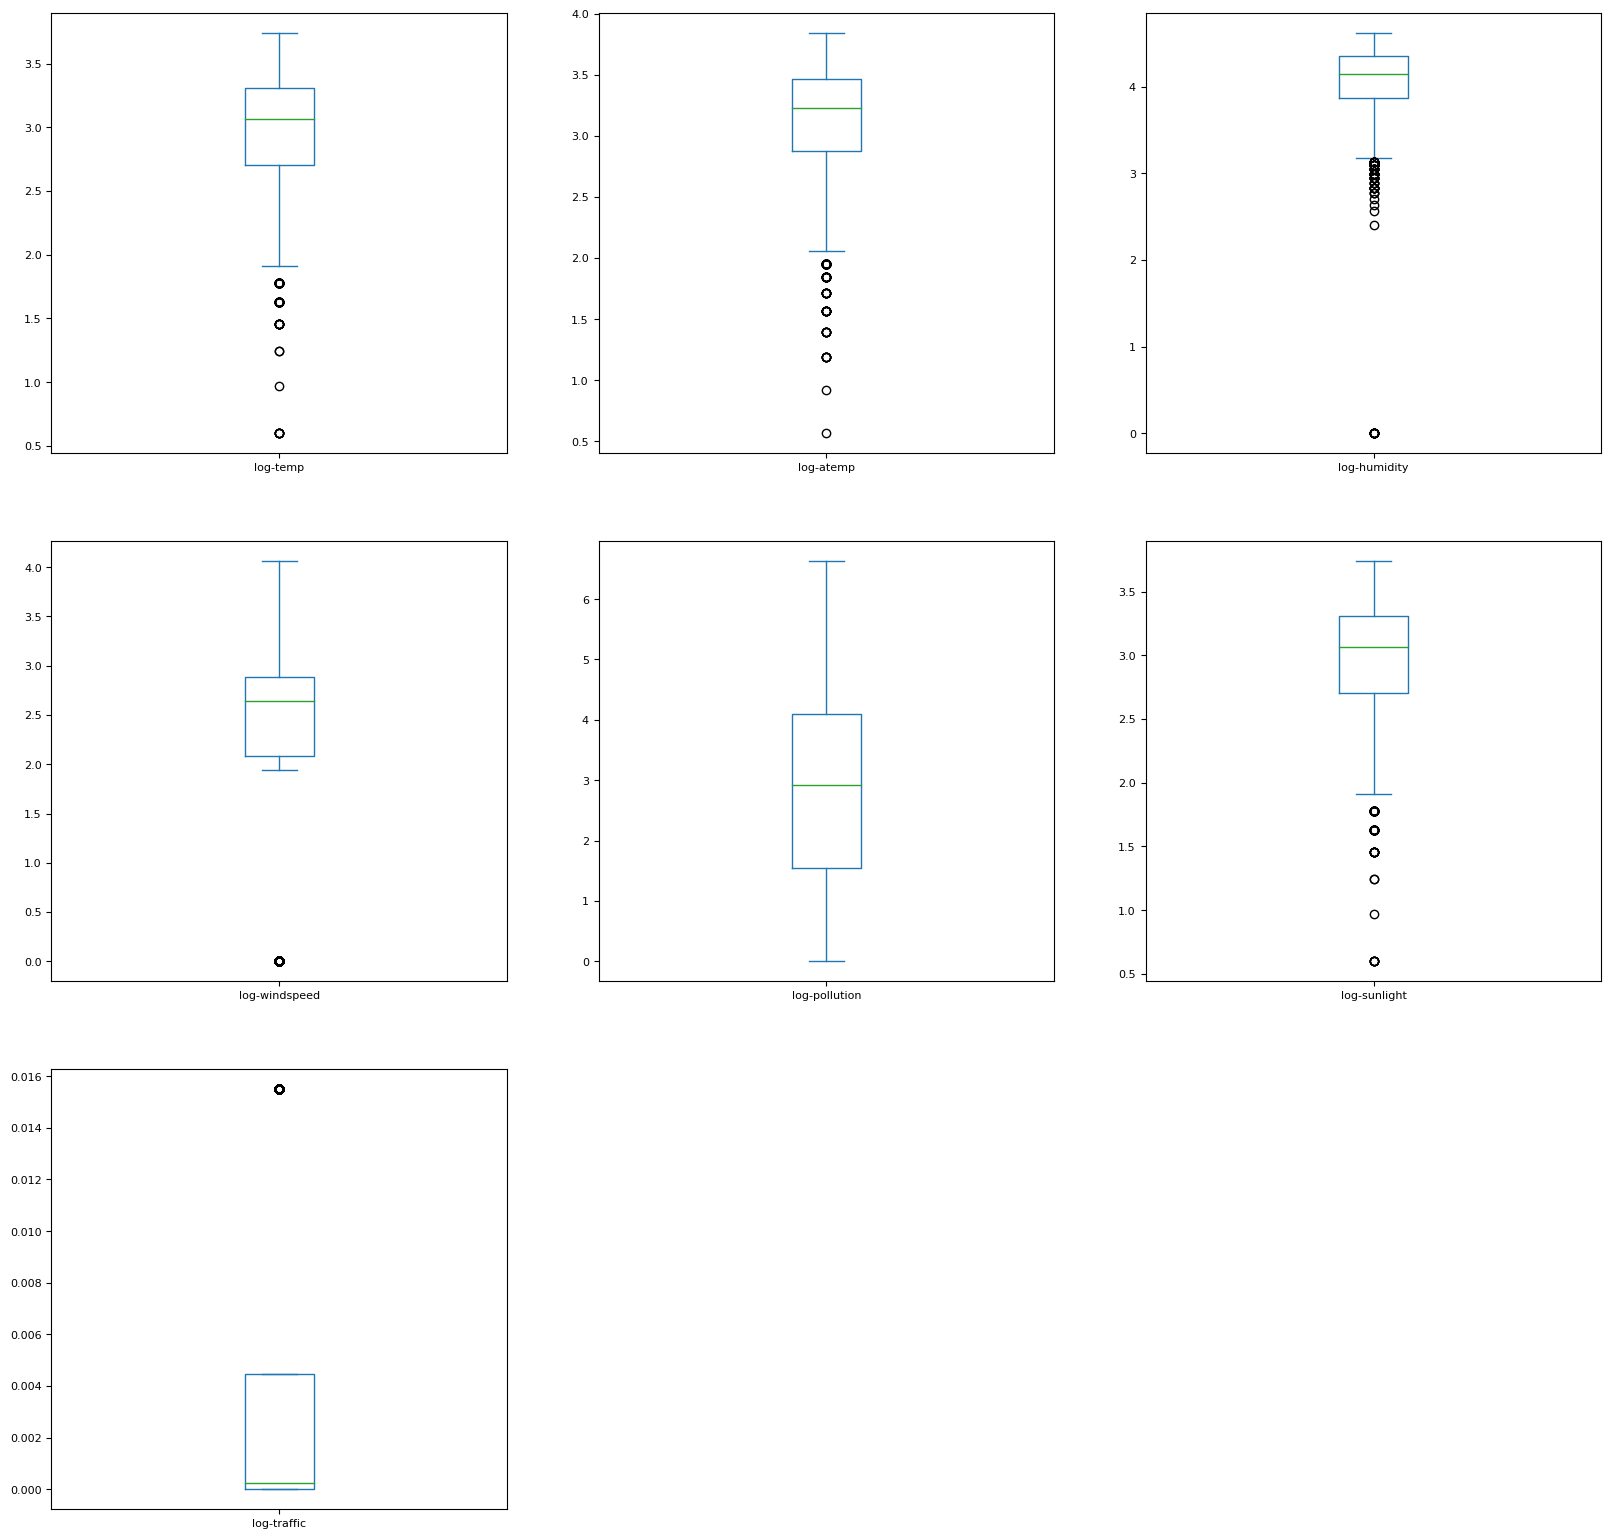

In [134]:
# Selecting float-type features
float_features = train_data.select_dtypes(include=[np.float64, np.float32, np.int64])

# Applying logarithmic transformation
log_train_data = float_features.apply(np.log1p)

# Creating a copy of the original DataFrame
transformed_train_data = train_data.copy()

# Renaming columns with 'log-' prefix
log_feature_names = ['log-' + col for col in log_train_data.columns]
log_train_data.columns = log_feature_names

# Plotting boxplots with logarithmic values
log_train_data.plot(kind="box", subplots=True, layout=(6, 3), figsize=(20, 40))
plt.show()

Based on the earlier distribution visualisations and the box plots presented above, it appears that:
* **'temp' and 'atemp'** - are normaly distributed.
* **'humidity'** - is normaly distributed. Also, 0% and 100% are a bit extreme for values so we need to make sure we clear those out.
* **log of 'pollution'** - is close enough to normally distributed.
* **'sunlight'** - is normaly distributed.
* **'traffic'** - strenghtening our hypothesis that this feature should be removed.

Final check for normality just to be sure:

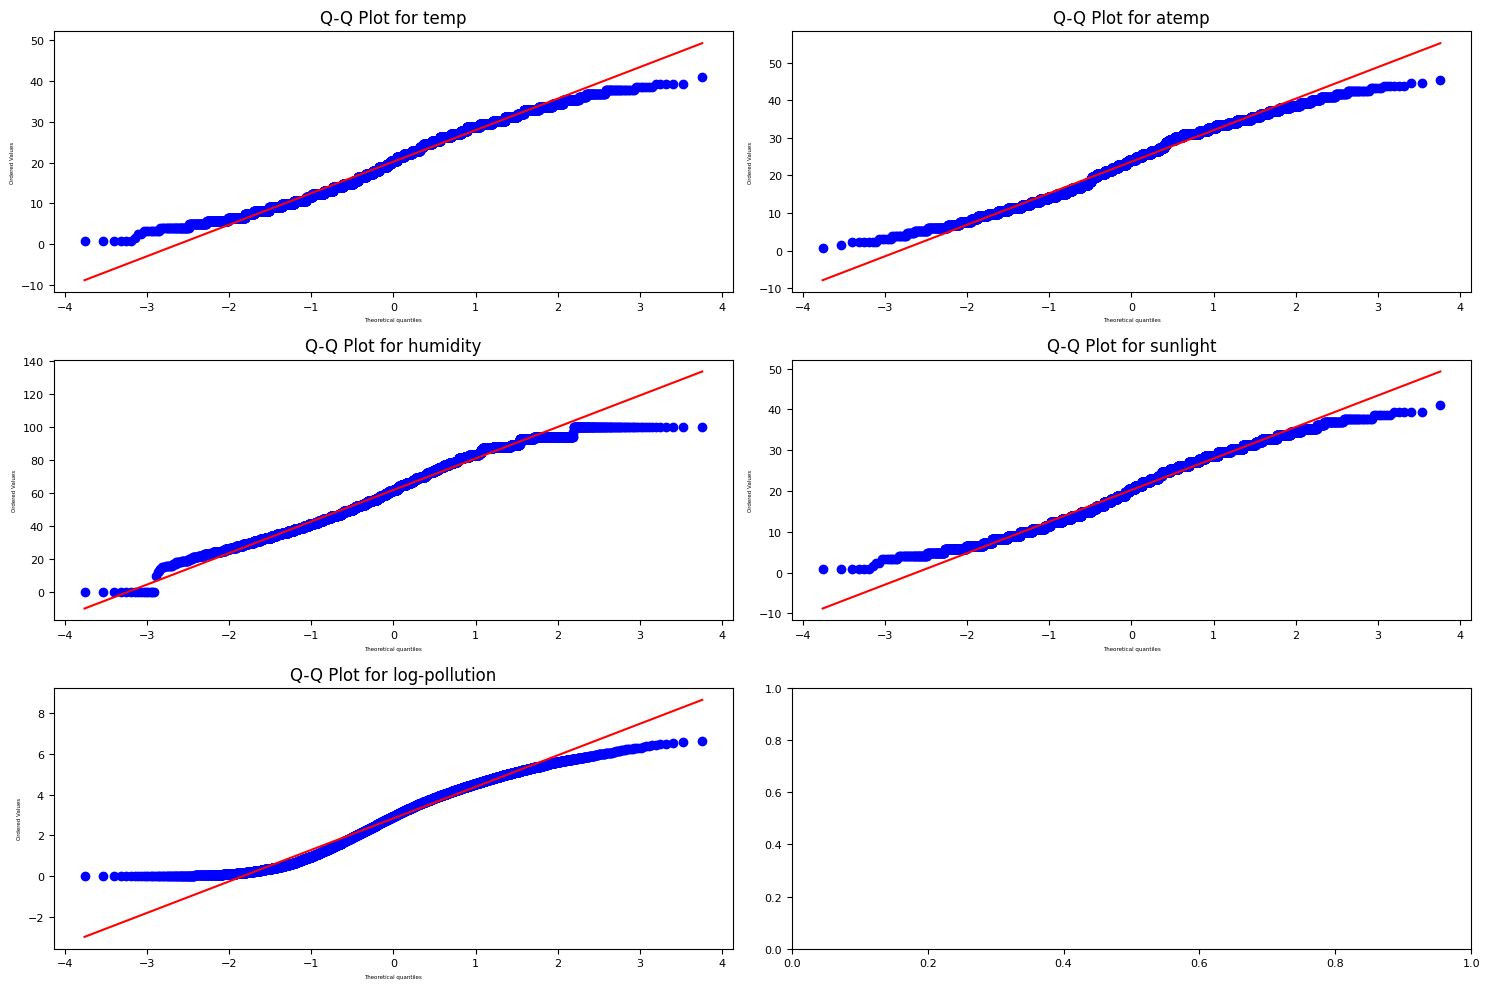

In [135]:
# Determine the number of rows and columns for the grid
num_rows = 3  # Number of rows in the grid
num_cols = 2  # Number of columns in the grid

# Select specific features from each DataFrame
selected_features_train = train_data[['temp', 'atemp', 'humidity', 'sunlight']]
selected_features_log_train = log_train_data[['log-pollution']]

# Combine the normaly distributed data to one DataFrame
ND_data = pd.concat([selected_features_train, selected_features_log_train], axis=1)

# Create the grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over each column in ND_data
for i, column in enumerate(ND_data.columns):
    # Create Q-Q plot
    stats.probplot(ND_data[column], dist="norm", plot=axes[i])

    # Set plot title
    axes[i].set_title(f"Q-Q Plot for {column}")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


Seems like indeed our findings were true:

* **'temp' and 'atemp'** - are normally distributed.
* **'humidity'** - is normally distributed. Also, 0% and 100% are a bit extreme for values so we need to make sure we clear those out.
* **'sunlight'** - is normally distributed.
* **log of 'pollution'** - is close enough to normally distributed.

In order to find outliers we categorized the features to normaly distributed and not normaly disbributed, By finding the normaly distributed features, we will be able to implement the IQR method for outliers and remove them accordingly later.


In the functions below we will plot the outliers according to the IQR method with several plots and draw conclusions afterwards:

In [136]:
def identify_bounds(df, feature, lower_percentile = 0.25, upper_percentile = 0.75, threshold=1.5):
    # Calculate the specified percentiles
    p1 = df[feature].quantile(lower_percentile)
    p2 = df[feature].quantile(upper_percentile)
    spread = p2 - p1

    # Define the upper and lower bounds
    lower_bound = p1 - threshold * spread
    upper_bound = p2 + threshold * spread

    # print(f"For {feature} the threshold given {threshold}, Lower Bound: '{lower_bound}', Upper Bound: '{upper_bound}'.")
    return lower_bound, upper_bound

In [137]:
def visualize_outliers_histogram(df, feature, ax, lower_bound, upper_bound, fontsize=10):
    # Plot histogram of the feature
    ax.hist(df[feature], bins=20)
    ax.set_title(f"Histogram of {feature}")
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)

    # Mark the outliers on the plot
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    ax.scatter(outliers[feature], np.zeros_like(outliers[feature]), color='red', marker='x', label='Outliers')

    ax.legend()

def visualize_outliers_scatter(df, feature, ax, lower_bound, upper_bound, fontsize=10):
    # Identify the outliers
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

    # Visualize the outliers
    ax.scatter(df['count'], df[feature], color='blue', label='Data')
    ax.scatter(outliers['count'], outliers[feature], color='red', label='Outliers')
    ax.set_xlabel('Bike Rental Count', fontsize=10)
    ax.set_ylabel(feature, fontsize=10)
    ax.set_title(f'Outliers in {feature}')
    ax.legend()

def visualize_outliers_boxplot(df, feature, ax, lower_bound, upper_bound, fontsize=10):
    # Create a boxplot of the feature
    sns.boxplot(data=df, y=feature, ax=ax, width=0.5)
    ax.set_xlabel(f'{feature}', fontsize=10)
    ax.set_ylabel('Values', fontsize=10)
    ax.set_title(f'Boxplot of {feature}')


def plot_grid_outliers(df, features, plotting_funcs):
    num_cols = len(features)
    num_funcs = len(plotting_funcs)
    rows = num_cols
    cols = num_funcs

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 5 * rows))

    axes = axes.reshape(-1)  # Reshape axes to a 1D array

    for i, feature in enumerate(features):
        lower_bound, upper_bound = identify_bounds(df, feature)

        for j, plot_func in enumerate(plotting_funcs):

            ax = axes[i * num_funcs + j]  # Get the correct axis
            plot_func(df, feature, ax, lower_bound, upper_bound)

    fig.suptitle('Outlier view for the Normally Distributed Features\n\n', fontsize=16, wrap=True)
    # plt.figtext(0.5, 0.95, 'Outlier view for the Normally Distributed Features', ha='center', fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust the top spacing
    plt.tight_layout()
    plt.show()


In [138]:
def plot_normal_dist_outliers(IQR_data, IQR_features = ['temp', 'humidity', 'sunlight', 'log-pollution']):

    plotting_funcs = [visualize_outliers_histogram, visualize_outliers_scatter, visualize_outliers_boxplot]
    plot_grid_outliers(IQR_data, IQR_features, plotting_funcs)

In each row we plot one of the normally distributed features and mark the outliers.

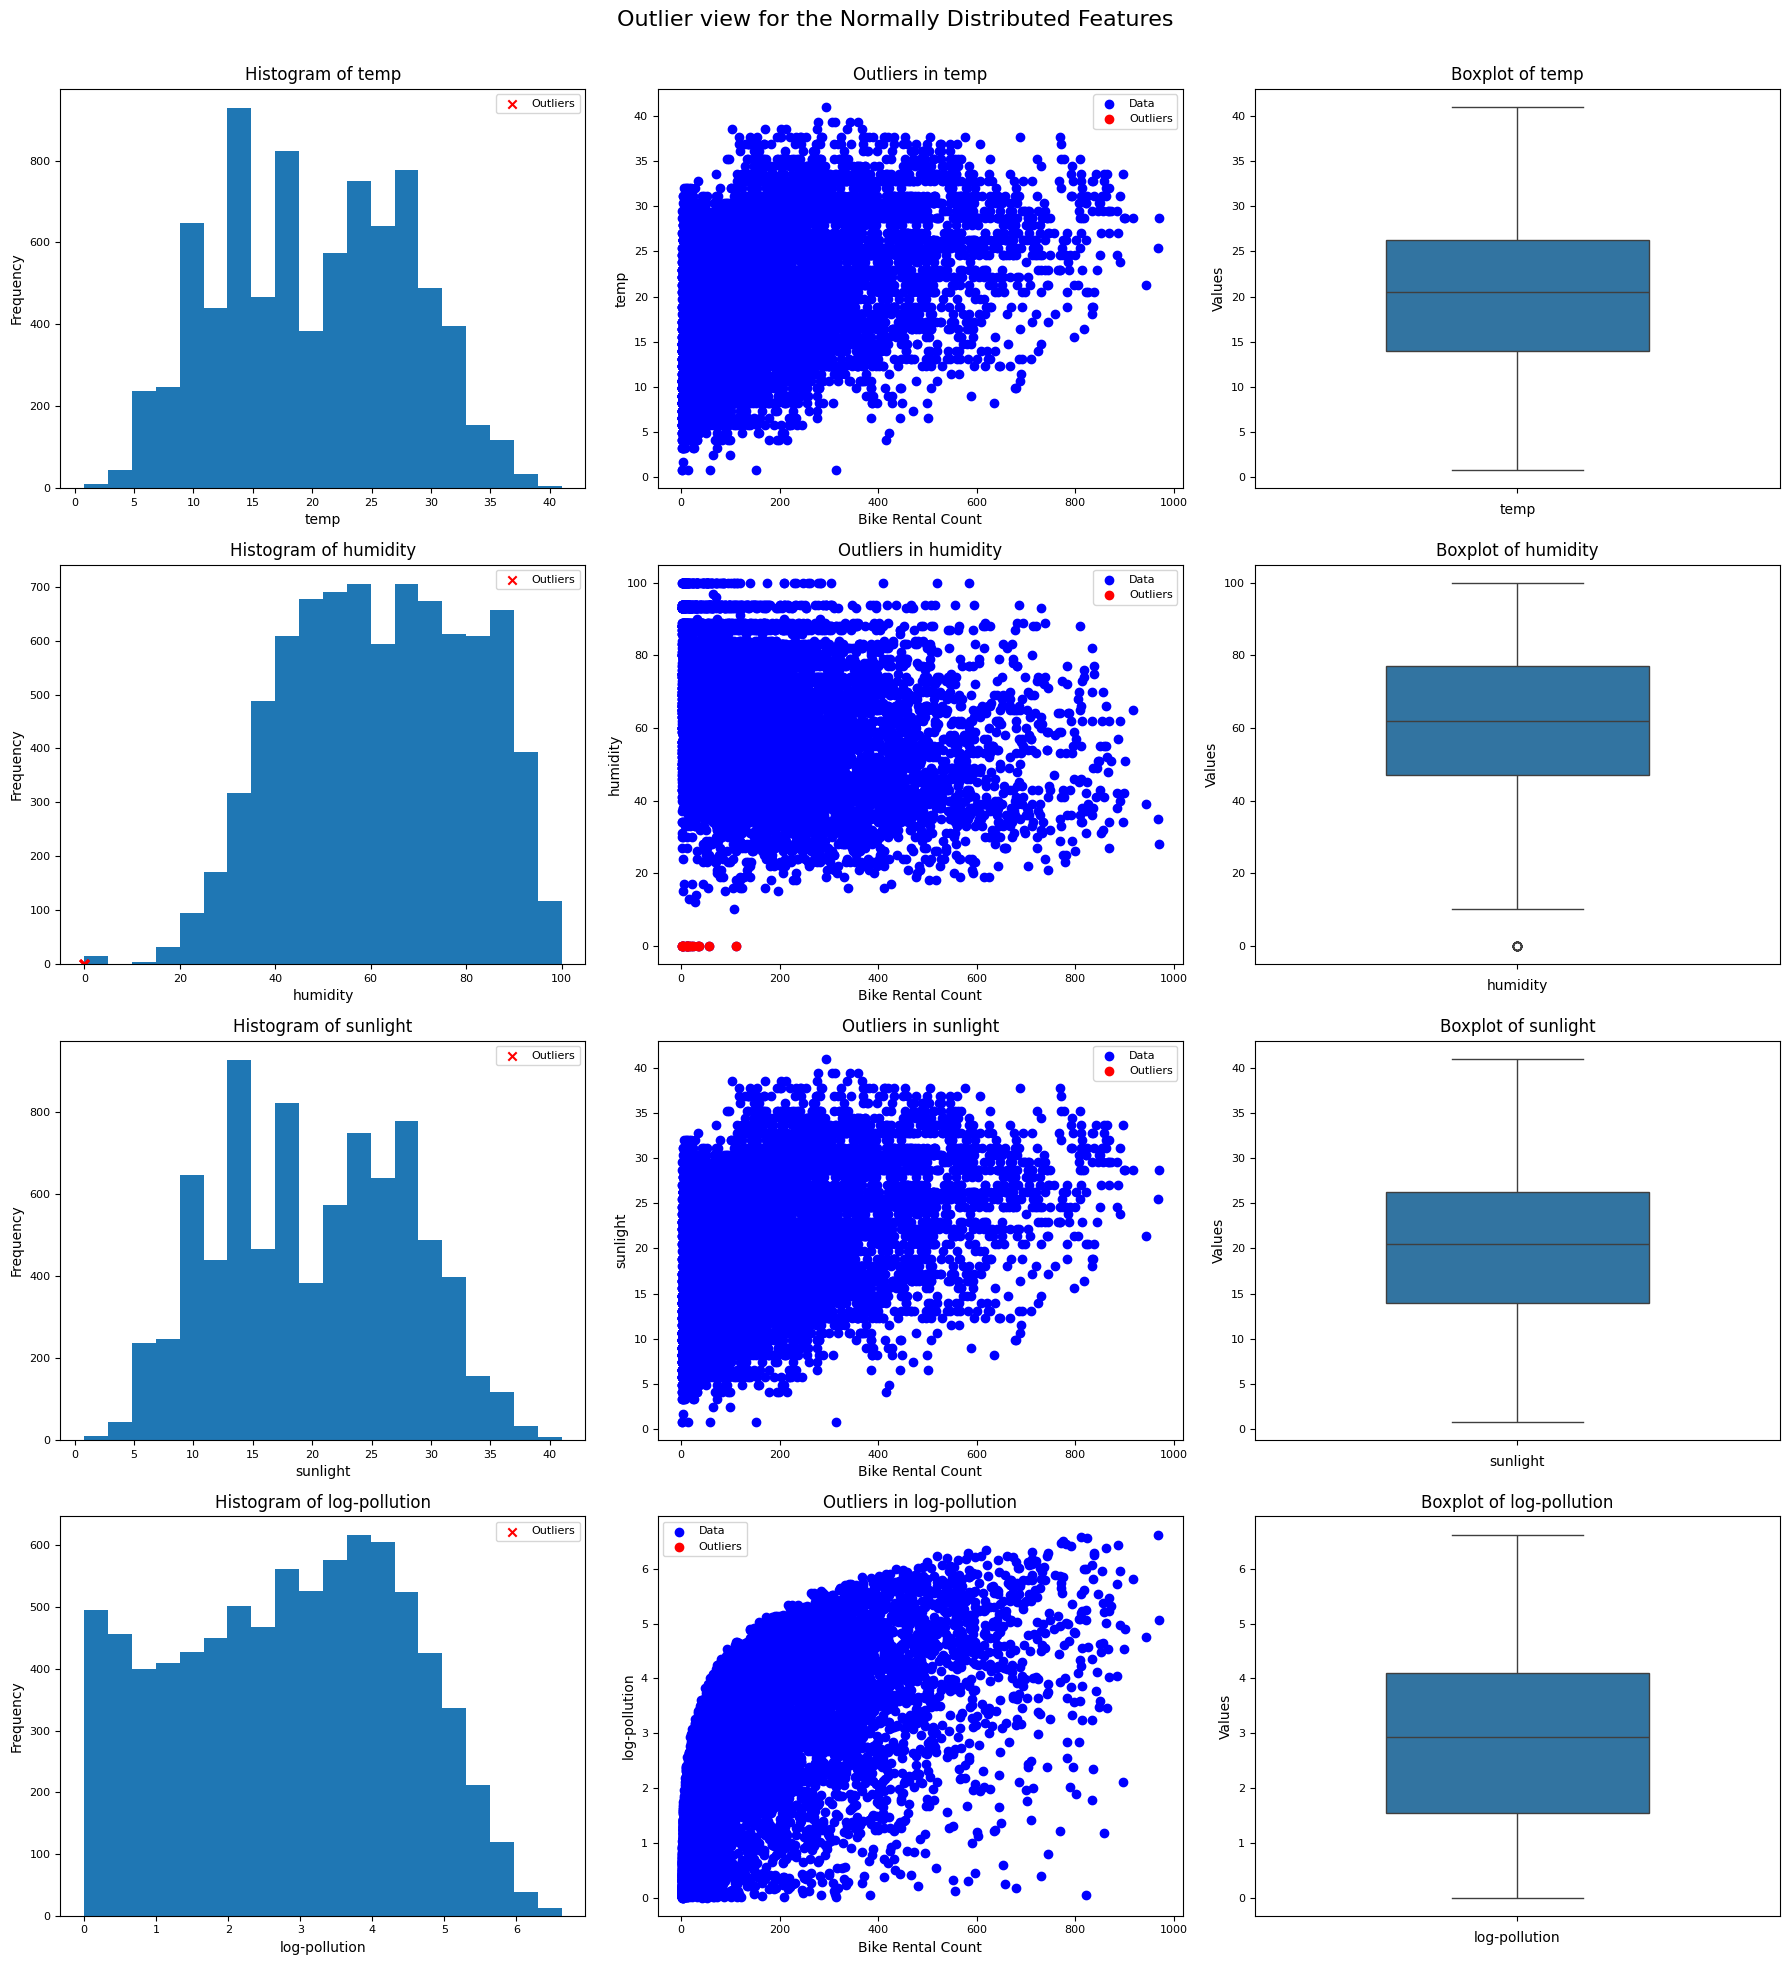

In [139]:
ND_data = pd.concat([ND_data, train_labels], axis=1)
plot_normal_dist_outliers(ND_data)

Looks like there are not many outliers.<br>
Using the IQR method we will remove all the outliers which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR.


In the preprocessing section we will handle these as decided.

Not forgetting about the other non-normally distributed, we will handle their outliers using Isolation Forest algorithm in the preprocessing section as well.

# Preprocessing

Here we would like to make sure that we are making a correct copy of the data that we will go over and make the changes in the pre-processing stage:

In [140]:
full_train_data_copy = full_train_data.copy()
Y_df = full_train_data_copy['count']
X_df = full_train_data_copy.drop('count', axis=1)

# Train split to train and validation with fixed random state (42) to ensure reproducibility
X_train, X_val, Y_train, Y_val = train_test_split(X_df, Y_df, test_size=0.2, random_state = 42, shuffle = True)

# Save copies in order to have a clean data set to use in the final preprocessing function
# (when pipelining all the functions from start to end)
X_train_ppc = X_train.copy()
Y_train_ppc = Y_train.copy()

X_val_ppc = X_val.copy()
Y_val_ppc = Y_val.copy()

## Add / Remove Features

Here we would like to add or delete features according to the conclusions from the EDA:

* **Insights from the correlation matrix -** We believed it would be more meaningful to keep temperature in the data and remove atemp and sunlight to enhance the accuracy in capturing the prevailing weather conditions at that specific time of the day. From a temperature feature (temp) we can  learn a lot about the average temperature feature (atemp) and the sunlight feature (sunlight).

* **'traffic' -** We would like to remove it from the data because it has a very low correlation with the label. Additionally, it contains unusual numbers whose meaning is difficult to explain, and the overall significance of this feature is unclear.

* **'datetime' -** We have split it into its constituent parts, providing all the necessary information for training the model. The datetime type holds no significance in this project; therefore, we opted to break it down into these categorical features: day, month, year, and hour, and remove 'datetime' fom the data.

* **'pollution'** - Log transformation brings large values closer together and spreads out small values. This compression can help reduce the influence of outliers. As we saw before in the boxplots, the 'pollution' feature has a lot of outliers, while the boxplot of the log transformation of this feature does not, so the transformation makes it more suitable for enhancing our model training. Consequently, we prefer to exclude 'pollution' and incorporate the logarithm of 'pollution' in our model.

TODO - 'Windspeed' feature to log ?!

In [141]:
def adding_new_features(df):
  # Adding log of pollution
  df['log_pollution'] = np.log1p(df['pollution'])

  # Adding day, month, year and hour features (function from EDA)
  df = timeseries_engineering(df)

  return df

In [142]:
def remove_features(df):
  # Remove 'atemp' and 'sunlight' variables to address multicollinearity
  multicollinearity_features = ['atemp', 'sunlight']
  df.drop(multicollinearity_features, axis=1, inplace=True)

  #remove traffic
  df.drop(['traffic'], axis=1, inplace=True)

  #remove datetime
  df.drop(['datetime'], axis=1, inplace=True)

  #remove pollution
  df.drop(['pollution'], axis=1, inplace=True)

  return df

In [143]:
def feature_engineering(df):
  df['datetime'] = pd.to_datetime(df['datetime'])
  df = adding_new_features(df)
  df = remove_features(df)
  return df

In [144]:
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)

In [145]:
X_train.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,log_pollution,day,month,year,hour
6560,1,0,0,1,9.02,80,0.0,2.469850,1,1,2011,1
3754,1,0,0,1,9.02,80,0.0,3.005163,1,1,2011,2
5381,1,0,0,1,9.02,80,0.0,0.092521,1,1,2011,6
5734,1,0,0,1,8.20,86,0.0,0.661408,1,1,2011,7
7481,1,0,0,1,13.12,76,0.0,0.922500,1,1,2011,9


In [146]:
X_val.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,log_pollution,day,month,year,hour
7767,1,0,0,1,9.84,75,0.0000,0.125285,1,1,2011,4
7272,1,0,0,2,9.84,75,6.0032,0.014234,1,1,2011,5
6329,1,0,0,1,14.76,81,19.0012,2.543857,1,1,2011,11
6048,1,0,0,2,17.22,82,19.9995,3.150552,1,1,2011,16
172,1,0,0,2,18.04,82,19.0012,3.181071,1,1,2011,17


## Handling Categorial Features


Here we are using the OneHotEncoder to encode the specified categorical features, creating dummy variables for each category.

In [147]:
def handle_categorial_features(df, categorial_features):
  # Create an instance of OneHotEncoder
  encoder = OneHotEncoder(sparse=False)

  # Fit and transform the selected columns
  encoded_columns = encoder.fit_transform(df[categorial_features])

  # Create custom feature names for the encoded columns
  feature_names = []
  for i, column in enumerate(categorial_features):
      categories = encoder.categories_[i]  # Use encoder.categories_ to get categories
      for feature in categories:
          feature_names.append(f'{column}_{feature}')

  # Create a DataFrame with the encoded columns and custom feature names
  encoded_data = pd.DataFrame(encoded_columns, columns=feature_names)
  # print(encoded_data.shape)

  data_reset = df.reset_index(drop=True)
  encoded_data_reset = encoded_data.reset_index(drop=True)

  # Concatenate the encoded columns with the original DataFrame
  data_encoded = pd.concat([data_reset, encoded_data_reset], axis=1)

  df = data_encoded

  df.drop(columns=categorial_features, inplace=True)
  return df

In [148]:
categorial_features = ['day', 'month', 'hour', 'year', 'season', 'weather']
non_categorial_features = ['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'log_pollution']
X_train = handle_categorial_features(X_train, categorial_features)
X_val = handle_categorial_features(X_val, categorial_features)

In [149]:
X_train.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'log_pollution', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'year_2011', 'year_2012',
       'season_1', 'season_2', 'season_3', 'season_4', 'weather_1',
       'weather_2', 'weather_3', 'weather_4'],
      dtype='object')

In [150]:
X_val.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'log_pollution', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'year_2011', 'year_2012',
       'season_1', 'season_2', 'season_3', 'season_4', 'weather_1',
       'weather_2', 'weather_3'],
      dtype='object')

Logically: after splitting into times by year, month, day and hour, then:
* Day - there are 7 days a week
* Month - there are 12 months in a year
* Hour - there are 24 round hours in a day
* Year - according to the data (the years that appear in the training data and additional years that may appear)

Also:
* Season and Weather - should be splitted into 4 categories.

That's why we have to make sure that all the dummy categories appear in every data set we will work with.

In [151]:
def ensure_all_categories(df, expected_categories):
    # Iterate through each categorical feature
    for feature, categories in expected_categories.items():
        # Check if the feature is in the DataFrame columns
        df_columns_list = list(df.columns)
        missing_categories = [cat for cat in categories if cat not in df_columns_list]

        # Add missing categories to the DataFrame
        if missing_categories:
            df = pd.concat([df, pd.DataFrame(0, index=df.index, columns=missing_categories)], axis=1)

        # Fill added categories with 0s
        df[categories].fillna(0, inplace=True)

    return df


In [152]:
def build_expected_categories():
    expected_categories = {}

    # Define categories for 'day'
    expected_categories['day'] = [f'day_{i}' for i in range(1, 32)]

    # Define categories for 'month'
    expected_categories['month'] = [f'month_{i}' for i in range(1, 13)]

    # Define categories for 'hour'
    expected_categories['hour'] = [f'hour_{i}' for i in range(24)]

    # Define categories for 'year'
    expected_categories['year'] = ['year_2011', 'year_2012', 'year_other']

    # Define categories for 'season'
    expected_categories['season'] = [f'season_{i}' for i in range(1, 5)]

    # Define categories for 'weather'
    expected_categories['weather'] = [f'weather_{i}' for i in range(1, 5)]

    return expected_categories


In [153]:
expected_categories = build_expected_categories()
X_train = ensure_all_categories(X_train, expected_categories)
X_val = ensure_all_categories(X_val, expected_categories)

In [154]:
X_train.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'log_pollution', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'year_2011', 'year_2012',
       'season_1', 'season_2', 'season_3', 'season_4', 'weather_1',
       'weather_2', 'weather_3', 'weather_4', 'day_20', 'day_21', 'day_22',
       'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29',
       'day_30', 'day_31', 'year_other

In [155]:
X_val.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'log_pollution', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'year_2011', 'year_2012',
       'season_1', 'season_2', 'season_3', 'season_4', 'weather_1',
       'weather_2', 'weather_3', 'day_20', 'day_21', 'day_22', 'day_23',
       'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30',
       'day_31', 'year_other', 'weather_4

Now we need to make sure that the order of the features in every df is the same - we will match our dfs according to the list of the categories we made:

In [156]:
fixed_categorial_features = []
for values_list in expected_categories.values():
    fixed_categorial_features.extend(values_list)

In [157]:
X_train = X_train[non_categorial_features+fixed_categorial_features]
X_val = X_val[non_categorial_features+fixed_categorial_features]

In [158]:
X_train.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'log_pollution', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'day_29', 'day_30', 'day_31', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'year_2011', 'year_2012', 'year_other',
       'season_1', 'season_2', 'season_3', 'season_4', 'weather_1',
       'weather_2', 'weather_3', 'weather_4

In [159]:
X_val.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'log_pollution', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
       'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'day_29', 'day_30', 'day_31', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'year_2011', 'year_2012', 'year_other',
       'season_1', 'season_2', 'season_3', 'season_4', 'weather_1',
       'weather_2', 'weather_3', 'weather_4

##  Outliers


As discussed above, we saw that there are several features that are normally distributed and some that do not.
Therfore, we will handle these as follows:

- There were a lot of outliers in 'pollution' so we applied log transformation on it and concluded that this feature is normally distributed.
- On the <u>Normally distributed</u> which are 'temp', 'humidity' and 'log_pollution' we will use the IQR method to identify them and replace them with the bound they are close to (Upper or Lower).

- On the <u>Non-normally distributed feature</u> which is 'windspeed' we will apply an Isolation Forest algorithm by learning on this feature and creating a decision whether a record is labeled as outlier or not. If it does, we will remove it.


<u>Normally Distributed Features:</u>

Applying the IQR Method on the train data - identifying the bounds of the normally distributed features and replacing them with the bounds accordingly:

In [160]:
ND_features = ['temp', 'humidity', 'log_pollution']
NND_features = ['windspeed']

In [161]:
def handle_ND_outliers_train(data, ND_features):

    # log_features = ['pollution']
    # data = apply_log(data, log_features)

    # normal_features = ['temp', 'humidity', 'log_pollution']
    bounds = {}

    for feature in ND_features:
        lower_bound, upper_bound = identify_bounds(data, feature)

        data[feature] = np.where(data[feature] < lower_bound, lower_bound, data[feature])
        data[feature] = np.where(data[feature] > upper_bound, upper_bound, data[feature])

        bounds[feature] = (lower_bound, upper_bound)

    return data, bounds

In [162]:
def handle_ND_outliers_test(data, feature_bounds):

    # log_features = ['pollution']
    # data = apply_log(data, log_features)

    for feature, (lower_bound, upper_bound) in feature_bounds.items():
        data[feature] = np.where(data[feature] < lower_bound, lower_bound, data[feature])
        data[feature] = np.where(data[feature] > upper_bound, upper_bound, data[feature])

    return data

<u>Non-Normally Distributed Features:</u><br>


For this task, we decided to use Isolation Forest algorithm. <br>
This algorithm trains and learns the bounds of each feature and then can be applied on every chosen dataset.
Since we want the train data to have the same charactaristics as the test model, we preffered to classify small amount of data as outliers.
Also, by doing so, we reduce the chances to overfitting, because the model trains on data that is pretty simillar to the tested one.
Therefore we chose the threshold and contamination hyperparameter to be both 0.01. TODO - maybe change the hyperparameter

Create the function to handle the non-normally distributed features in the training data:

In [163]:
def handle_NND_outliers_train(data, labels, threshold, contamination, NND_features):

  # Initialize the Isolation Forest model
  model = IsolationForest(contamination=contamination)

  # NND_features = ['windspeed']
  data_selected = data[NND_features].copy()

  model.fit(data_selected)

  outlier_scores = model.decision_function(data_selected)
  outlier_indices = np.where(outlier_scores < threshold)[0]

  data.reset_index(drop=True, inplace=True)
  labels.reset_index(drop=True, inplace=True)

  # Remove the outlier indices from the data
  data = data.drop(outlier_indices)
  labels = labels.drop(outlier_indices)

  return data, labels

Binding both of the decisions together:

In [164]:
def handle_outliers(X_train, Y_train, X_test):

  ND_features = ['temp', 'humidity', 'log_pollution']
  NND_features = ['windspeed']

  X_train, bounds = handle_ND_outliers_train(X_train, ND_features)
  X_test = handle_ND_outliers_test(X_test, bounds)

  contamination = 0.001
  threshold = 0.001
  X_train, Y_train = handle_NND_outliers_train(X_train, Y_train, threshold, contamination, NND_features)

  return X_train, Y_train, X_test

Before applying the changes, let's see the inital state:

In [165]:
X_train.describe()

,holiday,workingday,temp,humidity,windspeed,log_pollution,day_1,day_2,day_3,day_4,...,year_2012,year_other,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
count,6531.000000,6531.000000,6531.000000,6531.000000,6531.000000,6531.000000,6531.000000,6531.000000,6531.000000,6531.000000,...,6531.000000,6531.0,6531.000000,6531.000000,6531.000000,6531.000000,6531.000000,6531.000000,6531.000000,6531.000000
mean,0.028173,0.682438,20.233698,61.703108,12.825760,2.849588,0.049456,0.053897,0.050222,0.054050,...,0.505436,0.0,0.246057,0.249273,0.249885,0.254785,0.660236,0.261063,0.078548,0.000153
std,0.165480,0.465564,7.766792,19.298070,8.183028,1.574634,0.216836,0.225831,0.218419,0.226133,...,0.500009,0.0,0.430745,0.432625,0.432980,0.435774,0.473665,0.439248,0.269053,0.012374
min,0.000000,0.000000,0.820000,0.000000,0.000000,0.000304,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.940000,47.000000,7.001500,1.550074,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,20.500000,61.000000,12.998000,2.942397,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,26.240000,77.000000,16.997900,4.102217,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,39.360000,100.000000,56.996900,6.578431,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [166]:
X_val.describe()

,holiday,workingday,temp,humidity,windspeed,log_pollution,day_1,day_2,day_3,day_4,...,year_2012,year_other,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
count,1633.000000,1633.000000,1633.000000,1633.000000,1633.00000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,...,1633.000000,1633.0,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.0
mean,0.034293,0.686467,20.290104,62.363135,12.65365,2.801973,0.059400,0.056338,0.059400,0.051439,...,0.489284,0.0,0.244948,0.259032,0.249235,0.246785,0.669933,0.257195,0.072872,0.0
std,0.182036,0.464071,7.914070,19.082504,8.33741,1.562962,0.236444,0.230644,0.236444,0.220959,...,0.500038,0.0,0.430188,0.438238,0.432702,0.431273,0.470381,0.437222,0.260006,0.0
min,0.000000,0.000000,3.280000,0.000000,0.00000,0.000403,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,13.940000,47.000000,7.00150,1.534100,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,1.000000,20.500000,62.000000,11.00140,2.878282,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
75%,0.000000,1.000000,27.060000,78.000000,16.99790,4.070535,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0
max,1.000000,1.000000,41.000000,100.000000,56.99690,6.627121,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


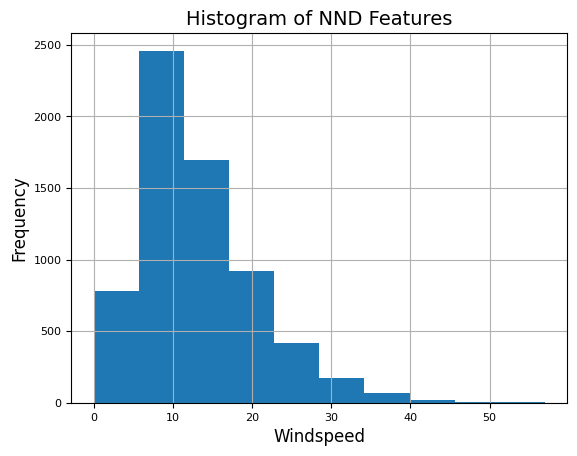

In [167]:
# selected_features = ['windspeed', 'log_pollution']
df = X_train[NND_features]
df.hist()
# Add x and y labels
plt.xlabel("Windspeed", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Histogram of NND Features", fontsize=14)
plt.show()

Let's see what outliers will be removed in the normally distributed features: (using the plotting function we created in the visualizations stage)

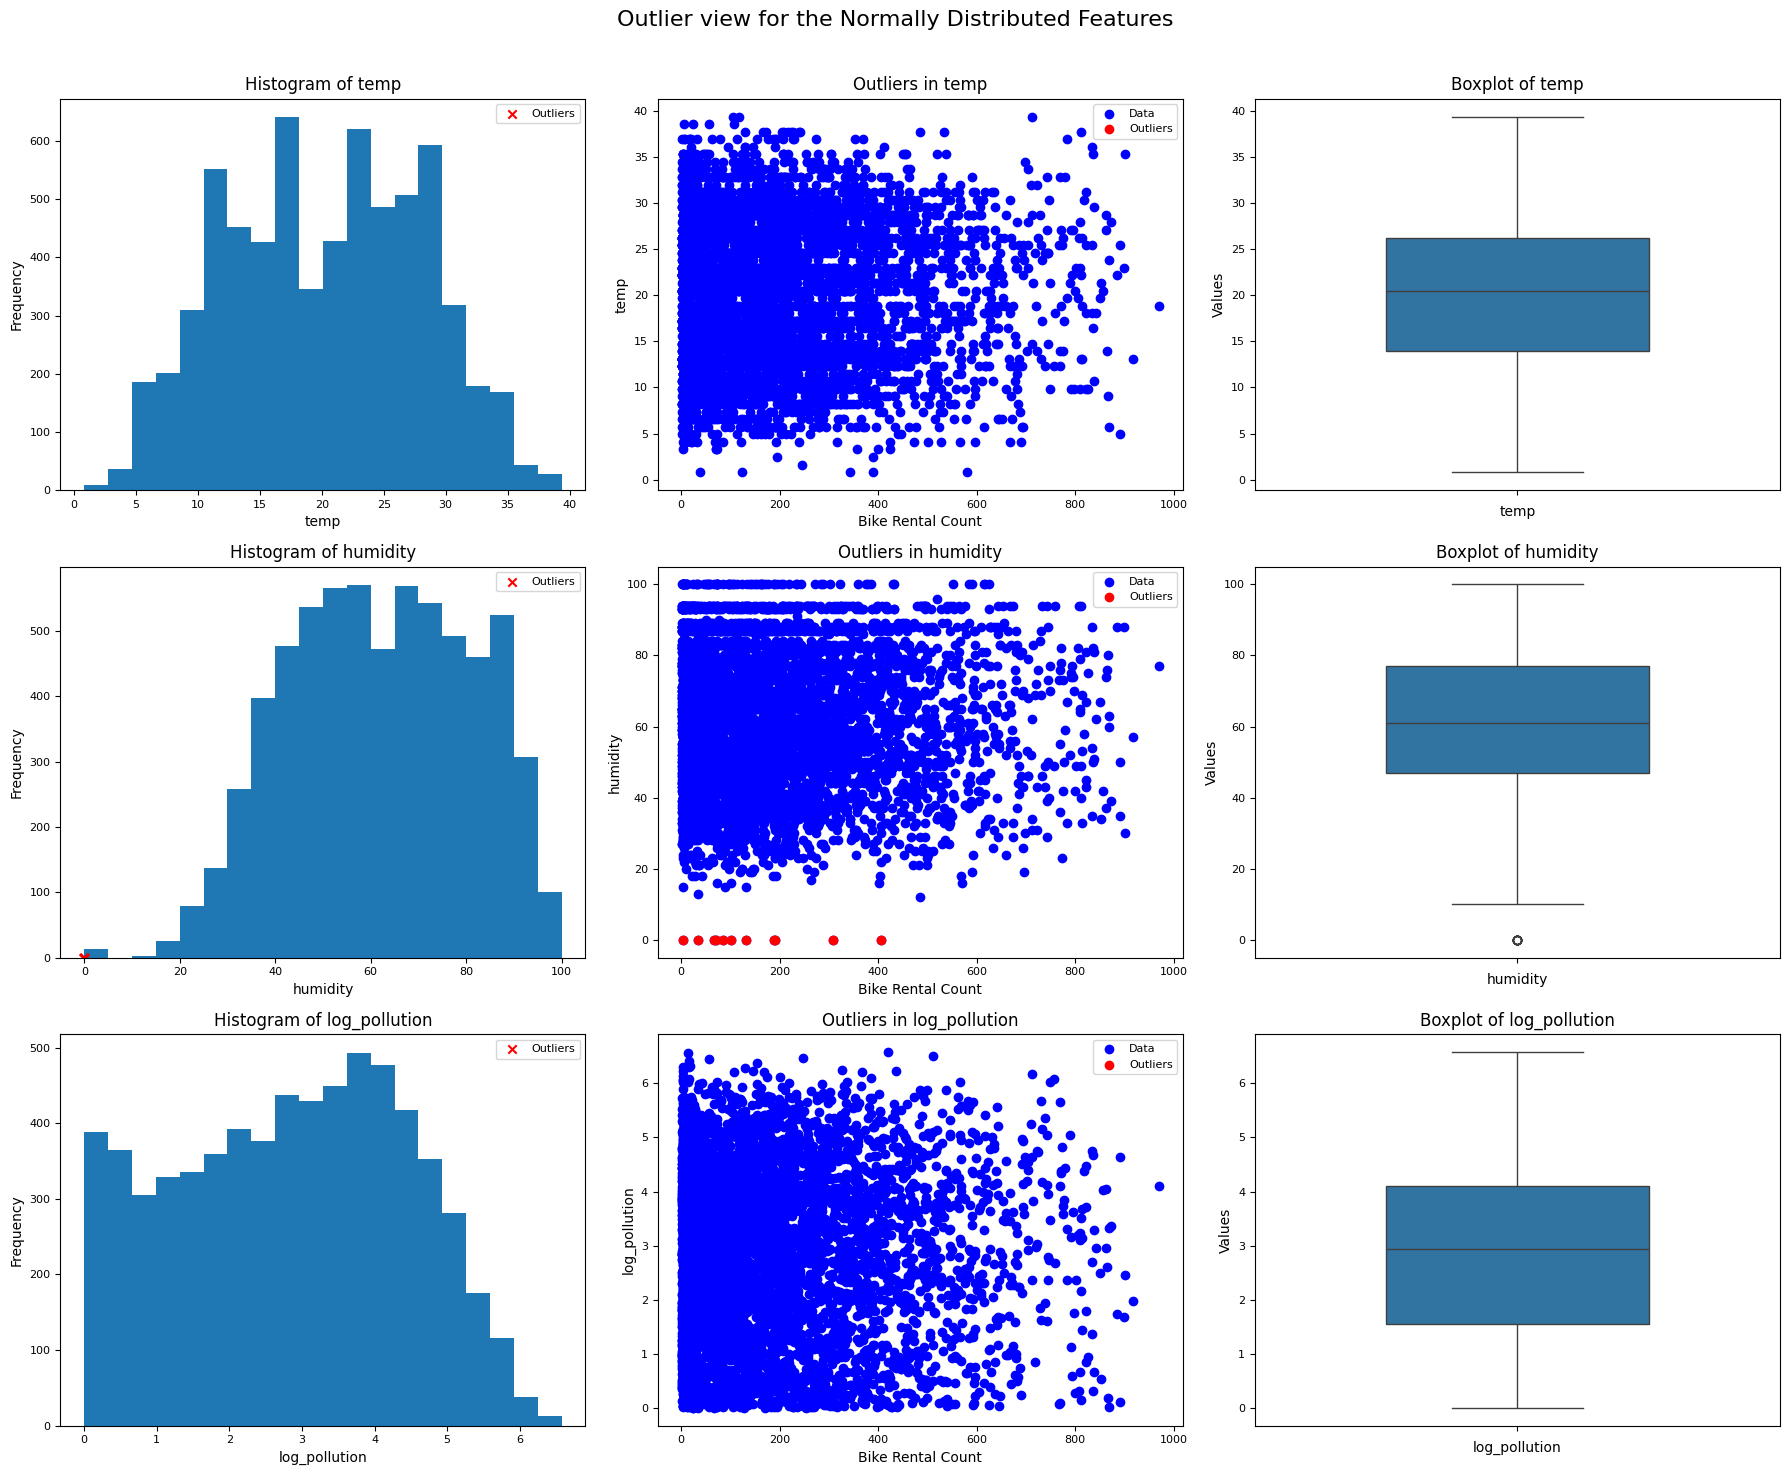

In [168]:
IQR_train = pd.concat([X_train, Y_train], axis=1)
# IQR_X_train = X_train[['temp', 'humidity', 'log_pollution']]
plot_normal_dist_outliers(IQR_train, ND_features)

Implementing the changes:

In [169]:
X_train, Y_train, X_test = handle_outliers(X_train, Y_train, X_val)

Now, we'll assess the impact

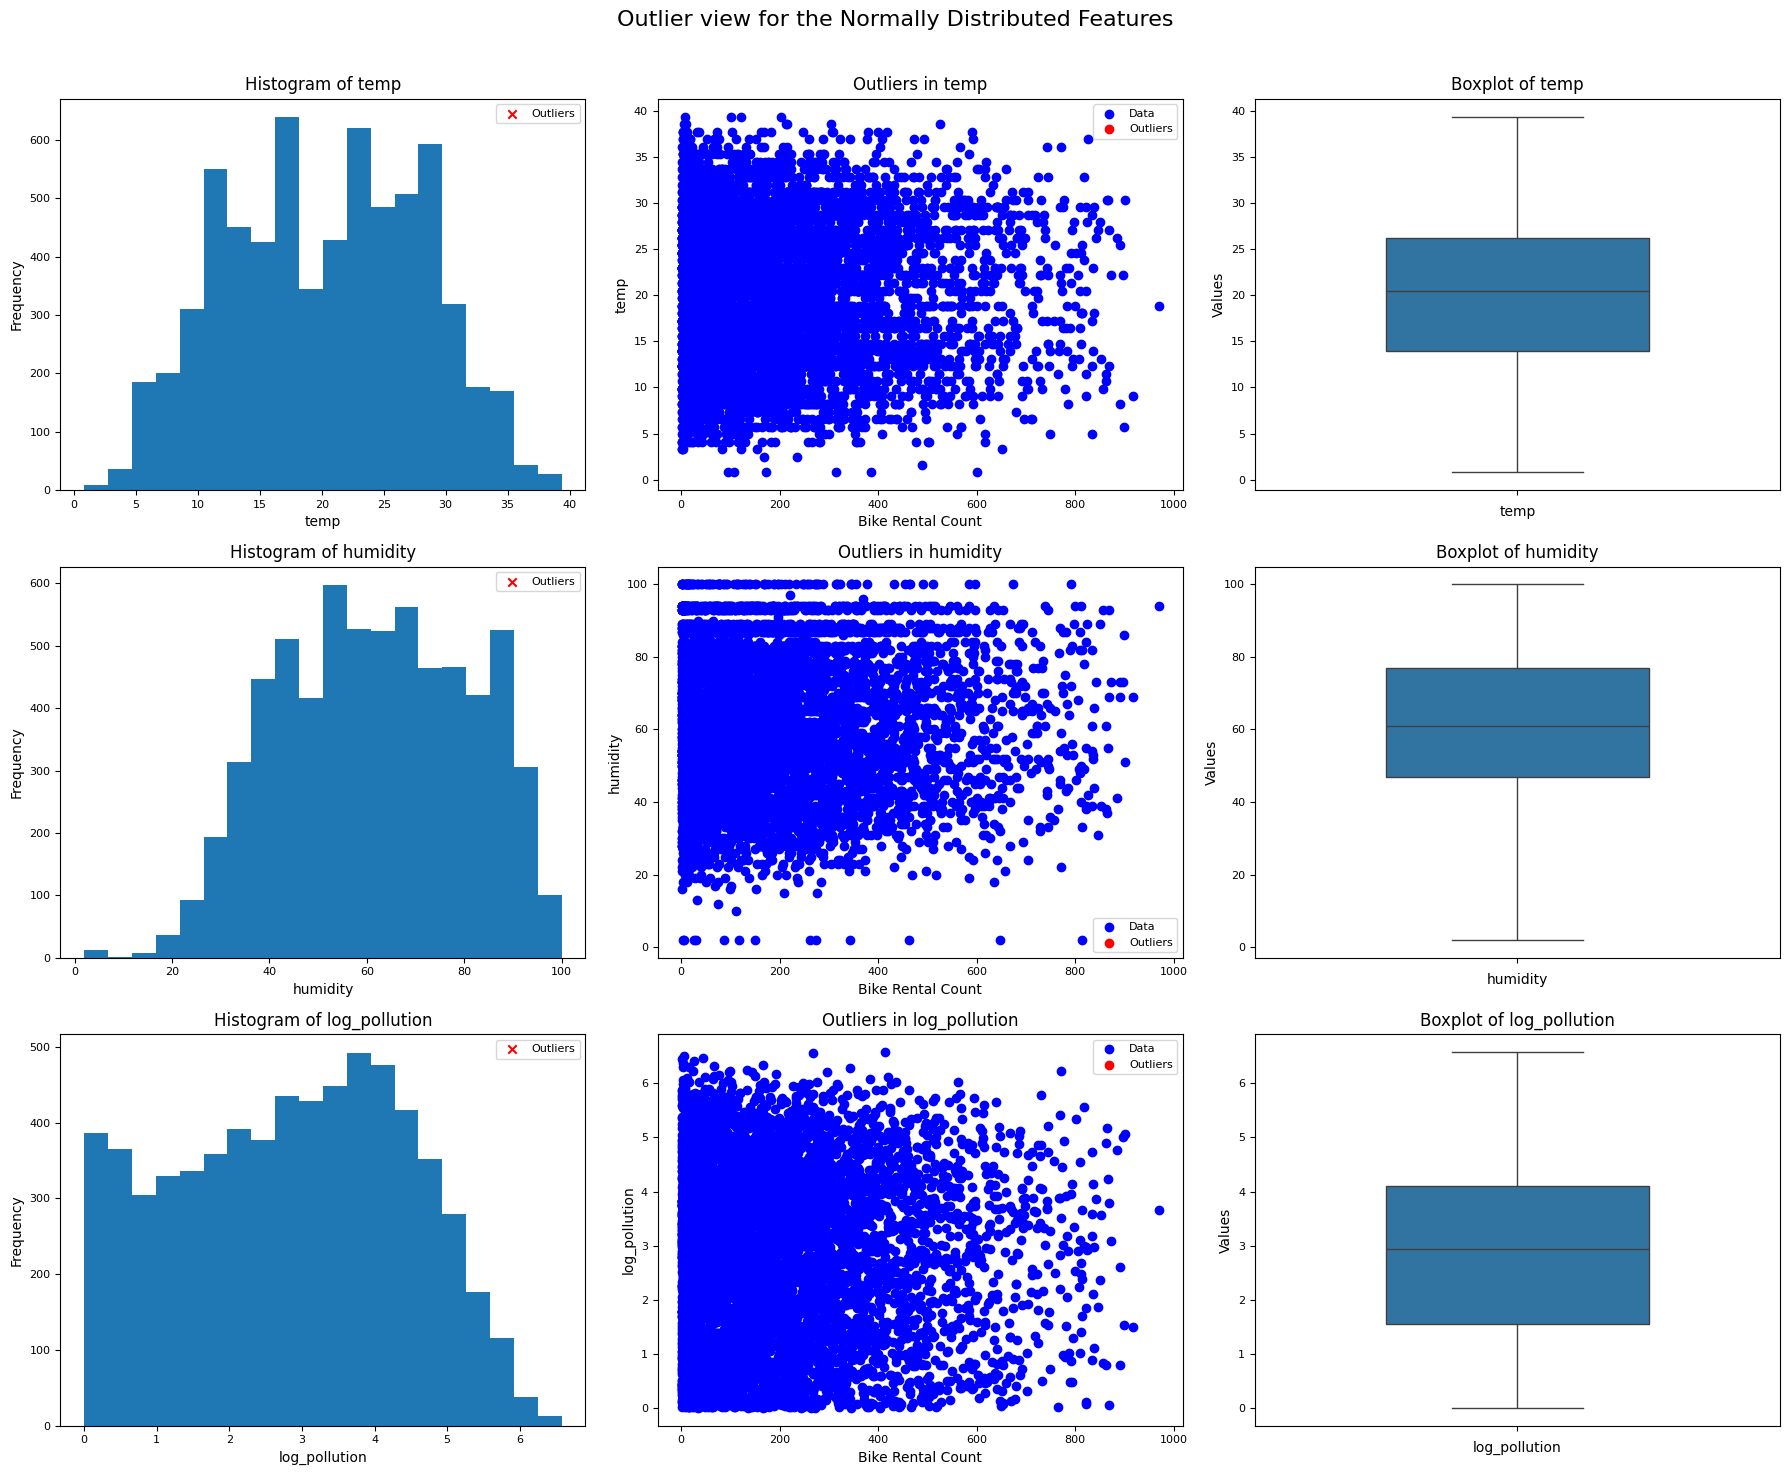

In [170]:
plot_normal_dist_outliers(pd.concat([X_train, Y_train], axis=1), ND_features)

We can observe that the outliers in the normally distributed features were reduced drastically!

And the other non-distributed features:

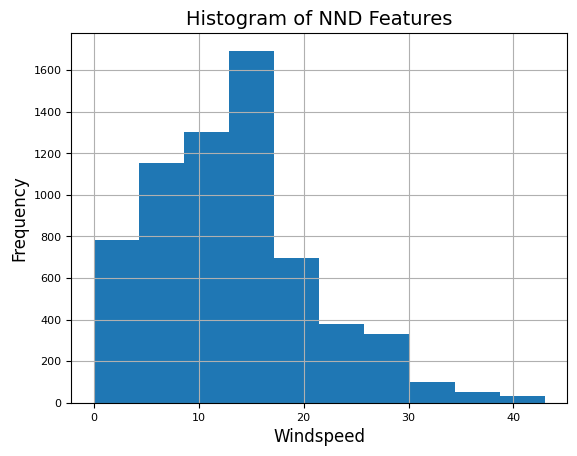

In [171]:
df = X_train[NND_features]
df.hist()
# Add x and y labels
plt.xlabel("Windspeed", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Histogram of NND Features", fontsize=14)
plt.show()

In [172]:
X_train.describe()

,holiday,workingday,temp,humidity,windspeed,log_pollution,day_1,day_2,day_3,day_4,...,year_2012,year_other,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
count,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,...,6521.000000,6521.0,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000
mean,0.028217,0.682564,20.235050,61.752339,12.772895,2.849162,0.049532,0.053979,0.049992,0.054133,...,0.505597,0.0,0.245208,0.249502,0.250115,0.255176,0.659868,0.261463,0.078516,0.000153
std,0.165604,0.465514,7.767676,19.259764,8.075364,1.574923,0.216993,0.225994,0.217946,0.226297,...,0.500007,0.0,0.430243,0.432758,0.433112,0.435993,0.473790,0.439465,0.269002,0.012383
min,0.000000,0.000000,0.820000,2.000000,0.000000,0.000304,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,13.940000,47.000000,7.001500,1.548207,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,20.500000,61.000000,12.998000,2.942397,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,26.240000,77.000000,16.997900,4.103024,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,39.360000,100.000000,43.000600,6.578431,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [173]:
X_val.describe()

,holiday,workingday,temp,humidity,windspeed,log_pollution,day_1,day_2,day_3,day_4,...,year_2012,year_other,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
count,1633.000000,1633.000000,1633.000000,1633.000000,1633.00000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,...,1633.000000,1633.0,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.000000,1633.0
mean,0.034293,0.686467,20.290104,62.365585,12.65365,2.801973,0.059400,0.056338,0.059400,0.051439,...,0.489284,0.0,0.244948,0.259032,0.249235,0.246785,0.669933,0.257195,0.072872,0.0
std,0.182036,0.464071,7.914070,19.074620,8.33741,1.562962,0.236444,0.230644,0.236444,0.220959,...,0.500038,0.0,0.430188,0.438238,0.432702,0.431273,0.470381,0.437222,0.260006,0.0
min,0.000000,0.000000,3.280000,2.000000,0.00000,0.000403,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,13.940000,47.000000,7.00150,1.534100,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.000000,1.000000,20.500000,62.000000,11.00140,2.878282,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0
75%,0.000000,1.000000,27.060000,78.000000,16.99790,4.070535,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0
max,1.000000,1.000000,41.000000,100.000000,56.99690,6.627121,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


We can conclude that indeed the outlier number has been dropped and the changes expected were made.

## Data Normalizing


In [174]:
def fit_normalize_data(df, scaler, col):
    df[[col]] = scaler.fit_transform(df[[col]])
    return df, scaler

def transform_normalize_data(df, scaler, col):
    df[[col]] = scaler.transform(df[[col]])
    return df

In [175]:
def normalize_data(X_train, X_val):
  columns_to_normalize = ['temp', 'humidity', 'windspeed','log_pollution']
  scaler = StandardScaler()
  for col in columns_to_normalize:
    X_train, scaler = fit_normalize_data(X_train, scaler, col)
    X_val = transform_normalize_data(X_val, scaler, col)

  return X_train, X_val

In [176]:
X_train, X_val = normalize_data(X_train, X_val)

In [177]:
X_train

,holiday,workingday,temp,humidity,windspeed,log_pollution,day_1,day_2,day_3,day_4,...,year_2012,year_other,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,0,0,-1.443921,0.947523,-1.581833,-0.240863,1.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,-1.443921,0.947523,-1.581833,0.099061,1.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,0,-1.443921,0.947523,-1.581833,-1.750467,1.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0,0,-1.549495,1.259077,-1.581833,-1.389224,1.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,0,-0.916052,0.739820,-1.581833,-1.223430,1.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6526,0,1,-0.388183,-0.610248,0.771332,0.632657,0.0,0.0,0.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6527,0,1,-0.388183,-0.610248,1.390323,0.122751,0.0,0.0,0.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6528,0,1,-0.599331,-0.610248,1.390323,1.596927,0.0,0.0,0.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6529,0,1,-0.599331,-0.610248,1.638418,0.154378,0.0,0.0,0.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [178]:
X_val

,holiday,workingday,temp,humidity,windspeed,log_pollution,day_1,day_2,day_3,day_4,...,year_2012,year_other,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
0,0,0,-1.338347,0.687894,-1.581833,-1.729662,1.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0,0,-1.338347,0.687894,-0.838379,-1.800180,1.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0,0,-0.704905,0.999448,0.771332,-0.193868,1.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,0,0,-0.388183,1.051374,0.894964,0.191383,1.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0,0,-0.282609,1.051374,0.771332,0.210763,1.0,0.0,0.0,0.0,...,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,0,1,-0.177036,-0.766025,2.133777,0.475550,0.0,0.0,0.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1629,0,1,-0.810478,-0.662174,-0.838379,-0.174271,0.0,0.0,0.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1630,0,1,-1.338347,0.687894,-0.838379,0.171730,0.0,0.0,0.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1631,0,1,-1.127200,0.687894,-0.714746,1.392660,0.0,0.0,0.0,0.0,...,1.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0


## PCA - Dimensionality Reduction

For explained variance: 0.5 number of dimensions: 4
For explained variance: 0.6 number of dimensions: 7
For explained variance: 0.7 number of dimensions: 10
For explained variance: 0.8 number of dimensions: 22
For explained variance: 0.9 number of dimensions: 39
For explained variance: 0.95 number of dimensions: 49
For explained variance: 0.99 number of dimensions: 58
For explained variance: 0.995 number of dimensions: 59
For explained variance: 0.9999 number of dimensions: 61


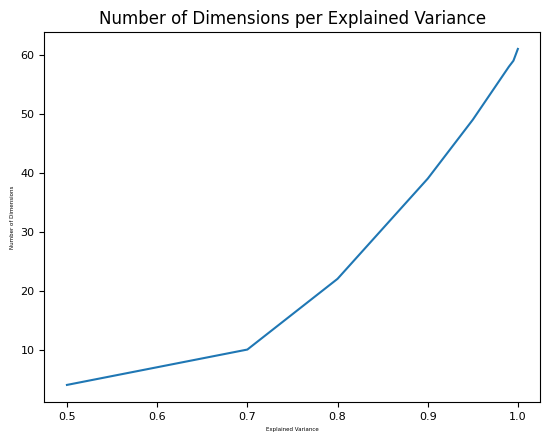

In [179]:
variance_vals = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995, 0.9999]
var_dim = []

for variance in variance_vals:
    pca = PCA(variance)
    data = pca.fit_transform(X_train)
    print("For explained variance:", variance, "number of dimensions:", data.shape[1])
    var_dim.append(data.shape[1])

plt.plot(variance_vals, var_dim)
plt.xlabel("Explained Variance")
plt.ylabel("Number of Dimensions")
plt.title("Number of Dimensions per Explained Variance")
plt.show()


We will choose: threshold=0.8

In [180]:
def perform_pca_with_variance(variance_threshold, train_data):
    pca = PCA(variance_threshold)
    transformed_data = pca.fit_transform(train_data)
    return pca, transformed_data

def apply_pca_transformation(pca, data):
    transformed_data = pca.transform(data)
    return transformed_data

In [181]:
variance_threshold = 0.8

pca, X_train_reduced = perform_pca_with_variance(variance_threshold, X_train)
X_train_reduced = pd.DataFrame(X_train_reduced)

X_val_reduced = apply_pca_transformation(pca, X_val)
X_val_reduced = pd.DataFrame(X_val_reduced)

In [182]:
X_train_reduced

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-2.017800,0.061153,-1.228047,0.420764,-0.766913,-0.012084,0.497589,-0.904837,0.586786,0.101380,...,-0.080892,-0.197687,-0.400830,-0.273498,-0.433119,0.239492,-0.082349,-0.085753,0.069757,-0.036697
1,-1.835472,0.007894,-1.432761,0.270840,-0.830469,-0.008904,0.521694,-0.949087,0.596714,0.095330,...,-0.069217,-0.200471,-0.416676,-0.258033,-0.412465,0.233178,-0.036253,-0.071325,0.064834,-0.074984
2,-2.850698,0.298267,-0.324034,1.101967,-0.466666,-0.024895,0.404526,-0.725136,0.609867,0.106668,...,-0.088574,-0.194656,-0.407241,-0.278540,-0.440082,0.229816,-0.075314,-0.046567,0.068937,-0.004977
3,-2.859384,0.173738,-0.559562,0.718136,-0.553711,-0.070532,0.424376,-0.878751,0.600812,0.084277,...,-0.070522,-0.188268,-0.430714,-0.260823,-0.426385,0.252393,-0.048458,-0.045182,-0.015690,-0.044774
4,-2.184729,-0.018699,-0.460069,1.035649,-0.563453,0.027495,0.447515,-0.672172,0.608873,0.246957,...,-0.095311,-0.198480,-0.410517,-0.285839,-0.421402,0.214285,-0.049556,-0.073241,0.022248,-0.059591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6516,0.812337,0.861354,-0.534632,-0.399923,0.446148,-0.770119,-0.580384,0.442578,-0.332522,-0.129977,...,0.629491,-0.073111,0.290095,-0.334954,-0.038463,-0.142731,-0.040525,-0.053582,-0.074293,-0.177814
6517,0.750452,1.265539,0.119680,-0.480561,0.574675,-0.865250,-0.632837,0.474285,-0.323908,-0.120216,...,0.634998,-0.040696,0.300589,-0.351390,-0.004908,-0.156261,-0.042506,-0.141500,-0.003582,-0.121809
6518,1.469511,1.157621,-0.877979,-1.204083,0.261757,-0.862164,-0.531009,0.234966,-0.340224,-0.222260,...,0.646000,-0.064648,0.291126,-0.343851,-0.016882,-0.093831,-0.058832,-0.135666,-0.067083,-0.177927
6519,0.750054,1.514095,0.145341,-0.655964,0.571273,-0.917718,-0.632096,0.414907,-0.331458,-0.206654,...,0.625811,-0.072298,0.263898,-0.322371,0.006808,-0.118351,-0.044596,-0.146273,-0.030213,-0.083875


In [183]:
X_val_reduced

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-2.664931,0.345300,-0.287263,1.289214,-0.448600,0.015149,0.402796,-0.618278,0.616404,0.139344,...,-0.095210,-0.218375,-0.408138,-0.280225,-0.420269,0.170586,-0.020026,-0.111146,0.048561,-0.100196
1,-2.599347,0.644383,0.209073,0.468752,-0.235354,0.735548,0.869411,0.233515,0.715501,0.027855,...,-0.064654,-0.161270,-0.445922,-0.281988,-0.399141,0.178040,-0.031995,-0.073299,-0.061950,-0.020575
2,-0.807583,0.804070,0.366815,-0.731934,-0.631095,-0.311540,0.456289,-0.956993,0.595811,0.291513,...,-0.054663,-0.213501,-0.446485,-0.352637,-0.368295,0.239714,-0.034418,-0.112702,0.068135,-0.046850
3,-0.583110,0.495824,0.395989,-1.427497,-0.521022,0.488001,0.951002,-0.123409,0.679141,0.331101,...,-0.042083,-0.175746,-0.455990,-0.378426,-0.359956,0.211786,-0.030811,-0.117958,0.096439,-0.084819
4,-0.567602,0.359914,0.348061,-1.366675,-0.533022,0.501599,0.954503,-0.116082,0.686432,0.349474,...,-0.044868,-0.185470,-0.472629,-0.361709,-0.367525,0.249236,-0.065787,-0.036181,0.096165,-0.102123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,1.391742,1.527803,0.405085,-0.892909,0.551022,-0.941601,-0.629209,0.443969,-0.316339,-0.106255,...,0.657818,-0.050952,0.261031,-0.357195,0.083397,-0.140370,-0.019737,-0.080323,0.061004,-0.028365
1629,-0.412653,0.423986,-1.129879,0.753521,0.501169,-0.576909,-0.600137,0.550544,-0.327457,-0.279064,...,0.619997,-0.039649,0.286084,-0.239958,0.037965,-0.136924,-0.074127,-0.135045,-0.003150,0.005056
1630,-1.200128,0.118412,-1.395264,-0.290717,0.427168,-0.778711,-0.612080,0.050716,-0.351055,-0.353811,...,0.592409,-0.048895,0.272702,-0.237776,-0.032146,-0.007589,-0.099555,-0.080094,-0.035181,-0.030713
1631,-0.362822,-0.138146,-1.989771,-0.907175,0.183407,-0.773974,-0.531720,-0.087112,-0.362270,-0.307737,...,0.590035,-0.056822,0.256418,-0.238707,-0.005059,0.007758,-0.079039,-0.105451,-0.087107,-0.072087


## Final Preprocessing Function

Now, after deciding what manipulations we will do on the train data (Outliers removal, Normalization, Missing values handling, Categorial data handling, Feature selection and Feature manipulation), we will create a generic preprocess function to run it all at once.

In [184]:
def preprocess_data(X_train, Y_train, X_test):

    # Add & remove features - 'proportion_imports'
    X_train = feature_engineering(X_train)
    X_test = feature_engineering(X_test)

    # Categorical Data Handling
    X_train, X_test = handle_categorial_features(X_train, X_test)
    X_train = ensure_all_categories(X_train, expected_categories)
    X_val = ensure_all_categories(X_val, expected_categories)
    X_train = X_train[non_categorial_features+fixed_categorial_features]
    X_val = X_val[non_categorial_features+fixed_categorial_features]

    # Outliers Removal
    X_train, Y_train, X_test = handle_outliers(X_train, Y_train, X_test)

    # Normalization
    X_train, X_test = normalize_data(X_train, X_test)

    return X_train, Y_train, X_test

In [185]:
def preproccess_data_with_pca(X_train, Y_train, X_test):
    # PCA - Dimensionality Reduction
    pca, X_train = perform_pca_with_variance(variance_threshold, X_train)
    X_train = pd.DataFrame(X_train)

    X_val = apply_pca_transformation(pca, X_test)
    X_val = pd.DataFrame(X_test)

    return X_train, Y_train, X_test


In [189]:
X_train_ppc

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pollution,sunlight,traffic,log_pollution,day,month,year,hour
6913,2012-05-19 03:00:00,2,0,0,1,20.50,24.240,48,7.0015,13.327268,20.501,0.000242,2.662165,19,5,2012,3
7753,2012-12-07 12:00:00,4,0,1,2,13.94,16.665,71,12.9980,11.678911,13.941,0.004489,2.539940,7,12,2012,12
3780,2012-08-14 07:00:00,3,0,1,2,27.06,30.305,83,6.0032,95.329124,27.061,0.015615,4.567771,14,8,2012,7
6710,2011-04-16 22:00:00,2,0,0,3,17.22,21.210,100,0.0000,9.297959,17.221,0.000000,2.331946,16,4,2011,22
4955,2012-01-14 06:00:00,1,0,0,1,5.74,7.575,50,0.0000,0.094263,5.741,0.000000,0.090081,14,1,2012,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2012-02-05 14:00:00,1,0,0,1,12.30,15.150,61,11.0014,3.068827,12.301,0.000000,1.403355,5,2,2012,14
5390,2011-04-14 01:00:00,2,0,1,1,15.58,19.695,76,15.0013,1.976179,15.581,0.000242,1.090640,14,4,2011,1
860,2011-12-07 10:00:00,4,0,1,3,18.04,21.970,100,6.0032,4.960762,18.041,0.000000,1.785198,7,12,2011,10
7603,2011-12-15 03:00:00,4,0,1,2,13.12,16.665,70,8.9981,0.073546,13.121,0.000000,0.070967,15,12,2011,3


In [186]:
# Applying all the preprocessing decisions at once from start to end
X_train_ppc, Y_train_ppc, X_val_ppc = preprocess_data(X_train_ppc, Y_train_ppc, X_val_ppc)
X_train_pca_ppc, Y_train_pca_ppc, X_val_pca_ppc = preproccess_data_with_pca(X_train_ppc, Y_train_ppc, X_val_ppc)
# preprocessed_validation_labels = Y_val_ppc.copy()

TypeError: Cannot setitem on a Categorical with a new category (False), set the categories first

# Modeling

In [ ]:
#Random Forest
df = train_data.copy()
valid_df = validation_data.copy()
df_labels = train_labels.copy()
valid__df_labels= validation_labels.copy()

# Converting 'datetime' Feature
df['datetime'] = pd.to_datetime(df['datetime'])
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

# Drop the original 'datetime' column if needed
df = df.drop('datetime', axis=1)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 10,30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(df, df_labels)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

#Evaluation
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(valid_df)

mse = mean_squared_error(valid__df_labels, y_pred)
rmse = mse**0.5
print("Root Mean Squared Error on Test Set:", rmse)



In [ ]:
#Linear Regression Model


In [ ]:
#XGboost

#XGBOOST

# from sklearn.ensemble import GradientBoostingRegressor
# model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense


 #Building the GRADIENT BOOSTED Model on our dataset
# from sklearn.ensemble import GradientBoostingRegressor
# GB_model = GradientBoostingRegressor().fit(X_train, Y_train)


Now that we have the data, we can proceed to train a model. Given a set of features, our goal is to predict a real number - the value of the property. In other words, this is a regression probelm so we'll only consider regression algorithms. In today's examples we'll compare linear regression and random forest.

We'll create a dictionary to save the models:

In [ ]:
models = {'Random forest': None}

## Random forest
Let's setup a function that trains a random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

We'll use RandomizedSearchCV to find the best number of trees for our RF:

In [ ]:
def run_random_forest(x_train, y_train):
  rf = RandomForestRegressor(n_estimators=200, random_state=42)
  tuned_rf = GridSearchCV(estimator=rf,
                          param_grid={'max_features': ['auto', 'sqrt', 'log2', 1/3]},
                          scoring='neg_mean_squared_error',
                          cv=3,
                          verbose=3,
                          refit=True)
  tuned_rf.fit(x_train, y_train)
  return tuned_rf

## XGBoost

## Linear regression

## Run all models

Let's run all models:

In [ ]:
def run_all_models(x, y):
  models_dict = {}
  models_dict['Random forest'] = run_random_forest(x, y)
  # models_dict['Decision tree'] = run_decision_tree(x, y)
  # models_dict['Linear regression'] = run_linear_regression(x, y)
  # models_dict['Ridge regression'] = run_ridge_regression(x, y)
  return models_dict

In [ ]:
models = run_all_models(train_data, train_labels.values.ravel())

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END ...................max_features=auto;, score=nan total time=   0.0s
[CV 2/3] END ...................max_features=auto;, score=nan total time=   0.0s
[CV 3/3] END ...................max_features=auto;, score=nan total time=   0.0s
[CV 1/3] END ...................max_features=sqrt;, score=nan total time=   0.0s
[CV 2/3] END ...................max_features=sqrt;, score=nan total time=   0.0s
[CV 3/3] END ...................max_features=sqrt;, score=nan total time=   0.0s
[CV 1/3] END ...................max_features=log2;, score=nan total time=   0.0s
[CV 2/3] END ...................max_features=log2;, score=nan total time=   0.0s
[CV 3/3] END ...................max_features=log2;, score=nan total time=   0.0s
[CV 1/3] END .....max_features=0.3333333333333333;, score=nan total time=   0.0s
[CV 2/3] END .....max_features=0.3333333333333333;, score=nan total time=   0.0s
[CV 3/3] END .....max_features=0.3333333333333333

ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 345, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: '2012-10-07 12:00:00'

--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 345, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: '2011-07-11 00:00:00'


In [ ]:
models

Comparing their cross validation scores:

In [ ]:
cv_scores = {}
cv_scores['Random forest'] = models['Random forest'].best_score_
cv_scores['Decision tree'] = models['Decision tree'].best_score_
cv_scores['Ridge regression'] = models['Ridge regression'].best_score_
cv_scores['Linear regression'] = models['Linear regression'][1].mean()
cv_scores

In [ ]:
sns.set()
cv_scores_df = -pd.DataFrame.from_dict(cv_scores, orient='index')
cv_scores_df.plot.bar(rot=45, legend=False)

In [ ]:
models['Random forest'].best_params_

# Evaluating on validation set

## Overall comparison

## Feature selection & importance

Here we can learn and understand which of the models are more or less important and we can delete, add or change any features accordingly.

Let's find the importance of all features for each model and remove insignificant features:

In [ ]:
feature_importance_dict = {}

#### Tree based methods

For tree based models we can use SKLearn's built-in methods:

In [ ]:
def find_tree_feature_importance(model, columns):
  importance = model.feature_importances_
  importance *= 100 / np.max(importance)  # Normalize
  importance = pd.DataFrame(importance, index=columns, columns=["Importance"])
  importance = importance.sort_values(by=['Importance'], ascending=False)
  return importance

In [ ]:
feature_importance_dict['Random forest'] = find_tree_feature_importance(trained_models_dict['Random forest'], X_train.columns)
feature_importance_dict['Decision tree'] = find_tree_feature_importance(trained_models_dict['Decision tree'], X_train.columns)

#### Classical regression methods

One interpetation of feature importance for linear/ridge regression, is the normalized value of the estimator's coefficients:

In [ ]:
def find_normalized_lr_feature_importance(model, x_train):
  coefficients = {x_train.columns[i]: np.abs(model.coef_[i]) for i in range(len(x_train.columns))}
  coefficients_df = pd.DataFrame.from_dict(coefficients, orient='index', columns=['Importance'])
  coefficients_df['Importance'] *=  x_train.std()
  coefficients_df['Importance'] *= 100 / coefficients_df['Importance'].max()
  importance = coefficients_df.sort_values(by=['Importance'], ascending=False)
  return importance

In [ ]:
feature_importance_dict['Linear regression'] = find_normalized_lr_feature_importance(trained_models_dict['Linear regression'], X_train)

#### Comparison

Let's visualize the different feature imprtance across the models:

In [ ]:
sns.set()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
feature_importance_dict['Random forest'].plot(kind='barh', ax=axes[0, 0], legend=False, title='Random forest')
feature_importance_dict['XGBoost'].plot(kind='barh', ax=axes[0, 1], legend=False, title='XGBoost')
feature_importance_dict['Linear regression'].plot(kind='barh', ax=axes[1, 0], legend=False, title='Linear regression')


## Add/Remove Features - Improve Results

Lets try to improve our data to get better results:

* **'hour' -** We realized that there are too many hours (24 hours). We would prefer to categorize the data into time ranges: morning, afternoon, and evening. This is done to reduce the number of dimensions.
we will add 'time_in_day' feature:
  * 1 - Morning
  * 2 - Afternoon
  * 3 - Evening

In [ ]:
def add_time_in_day_feature(hour):
  if 4 <= hour < 12:
    return 1  # Morning
  elif 12 <= hour < 20:
    return 2  # Afternoon
  else:
    return 3  # Evening

def dealing_with_hours(df):
  # Adding time in day feature
  df['time_in_day'] = df['hour'].apply(add_time_in_day_feature)
  #remove hour
  df.drop(['hour'], axis=1, inplace=True)
  return df


## Model improvement

Running the models again after the changes:

# Prediction



1.   List item
2.   List item



# *Output*

צריך למלא את זה לפי מה שיצא לנו!!!


In [ ]:
import pandas as pd
# Keep keys the same, and replace values according to your results and the specified type

results = {'model': ['string1', 'string2', 'string3'],
           'Score (RMSE)': ['string1', 'string2', 'string3'],
           'Hyperparams used': [['list1'], ['list2'], ['list3']],
           'Features dropped': [['list1'], ['list2'], ['list3']],
           'New features created': [['list1'], ['list2'], ['list3']],
           'Runtime trainining + inference (seconds)': ['int1', 'int2', 'int3'],
           'Hardware used (GPU/CPU/TPU)': ['string1', 'string2', 'string3'],
           'Explainability (top 3 features)': [['list1'], ['list2'], ['list3']]
           }

df = pd.DataFrame(results)
df

In [ ]:
df.to_csv(os.path.join(os.getcwd(), 'example.csv'))

In [ ]:
#בדיקת המודל

import numpy as np
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))